# Assignment 7 - SVM on Donors choose dataset

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.downloader.download('vader_lexicon')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import chart_studio.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1.1) Reading the data

In [4]:
train_data = pd.read_csv(r"D:\Assignments of Applied AI\Donorschoose data set\train_data.csv")
resource_data = pd.read_csv(r"D:\Assignments of Applied AI\Donorschoose data set\resources.csv")

In [5]:
print('Number of data points in the train data', train_data.shape)
print('-'*127)
print('The attributes of the data points in the train data :', train_data.columns.values)
train_data.head(2)

Number of data points in the train data (109248, 17)
-------------------------------------------------------------------------------------------------------------------------------
The attributes of the data points in the train data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [6]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(train_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
train_data['Date'] = pd.to_datetime(train_data['project_submitted_datetime'])
train_data.drop('project_submitted_datetime', axis=1, inplace=True)
train_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
train_data = train_data[cols]

#train_data.head(2)

In [7]:
print("Number of data points in resource data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in resource data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

# 1.2) Preprocessing project_subject_categories

In [8]:
pro_sub_catogories = list(train_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
pro_sub_cat_list = []
for i in pro_sub_catogories:
    train = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        train+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        train = train.replace('&','_') # we are replacing the & value into 
    pro_sub_cat_list.append(train.strip())

In [9]:
train_data['clean_categories'] = pro_sub_cat_list
train_data.drop(['project_subject_categories'], axis=1, inplace=True)

In [10]:
from collections import Counter
my_counter = Counter()
for word in train_data['clean_categories'].values:
    my_counter.update(word.split())

In [11]:
pro_sub_cat_dict = dict(my_counter)
sorted_pro_sub_cat_dict = dict(sorted(pro_sub_cat_dict.items(), key=lambda kv: kv[1]))

# 1.3) Preprocessing project_subject_subcategories

In [12]:
pro_sub_subcatogories = list(train_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

pro_sub_subcat_list = []
for i in pro_sub_subcatogories:
    train = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        train +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        train = train.replace('&','_')
    pro_sub_subcat_list.append(train.strip())

In [13]:
train_data['clean_subcategories'] = pro_sub_subcat_list
train_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

In [14]:
from collections import Counter
my_counter = Counter()
for word in train_data['clean_subcategories'].values:
    my_counter.update(word.split())

In [15]:
pro_sub_subcat_dict = dict(my_counter)
sorted_pro_sub_subcat_dict = dict(sorted(pro_sub_subcat_dict.items(), key=lambda kv: kv[1]))

# 1.4) Text Preprocessing the titles

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
clean_titles = []

for titles in tqdm(train_data["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    clean_titles.append(title.lower().strip())

100%|███████████████████████████████| 109248/109248 [00:04<00:00, 23904.10it/s]


In [19]:
train_data["clean_titles"] = clean_titles

In [20]:
train_data.drop(['project_title'], axis=1, inplace=True)

## Number of words in titles

In [21]:
title_word_count = []

In [22]:
for a in train_data["clean_titles"] :
    b = len(a.split())
    title_word_count.append(b)

In [23]:
train_data["title_word_count"] = title_word_count

In [24]:
train_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   
76127     SpecialNeeds                        SpecialNeeds   

                              clean_titles  title_word_count  
55660  engineering steam primary classroom                 4  
76127                  sensory tools focus                 3

# 1.5) Combine 4 project essay

In [25]:
# merge two column text dataframe: 
train_data["essay"] = train_data["project_essay_1"].map(str) + train_data["project_essay_2"].map(str) + \
                        train_data["project_essay_3"].map(str) + train_data["project_essay_4"].map(str)

# 1.6) Text preprocessing the essay

In [26]:
clean_essay = []

for ess in tqdm(train_data["essay"]):
    ess = decontracted(ess)
    ess = ess.replace('\\r', ' ')
    ess = ess.replace('\\"', ' ')
    ess = ess.replace('\\n', ' ')
    ess = re.sub('[^A-Za-z0-9]+', ' ', ess)
    ess = ' '.join(f for f in ess.split() if f not in stopwords)
    clean_essay.append(ess.lower().strip())

100%|████████████████████████████████| 109248/109248 [01:28<00:00, 1236.90it/s]


In [27]:
train_data["clean_essays"] = clean_essay

In [28]:
train_data.drop(['essay'], axis=1, inplace=True)

## Number of words in Essay

In [29]:
essay_word_count = []

In [30]:
for ess in train_data["clean_essays"] :
    c = len(ess.split())
    essay_word_count.append(c)

In [31]:
train_data["essay_word_count"] = essay_word_count

In [32]:
train_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   
76127     SpecialNeeds                        SpecialNeeds   

                              clean_titles  title_word_count  \
55660  engineering steam primary classroom                 4   
76127                  sensory tools focus                 3   

                                            clean_essays  essay_word_count  
55660  i fortunate enough use fairy tale stem kits cl...               175  
76127  imagine 8 9 years old you third grade classroo...               179

# 1.7) Calculate sentiment score in essay

In [33]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [34]:
neg = []
pos = []
neu = []
compound = []

for a in tqdm(train_data["clean_essays"]) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg.append(b)
    pos.append(c)
    neu.append(d)
    compound.append(e)

100%|██████████████████████████████████| 109248/109248 [20:28<00:00, 92.96it/s]


In [35]:
train_data["pos"] = pos

In [36]:
train_data["neg"] = neg

In [37]:
train_data["neu"] = neu

In [38]:
train_data["compound"] = compound

In [39]:
train_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  ...  \
55660  Each month I try to do several science or STEM...  ...   
76127  It is tough to do more than one thing at a tim...  ...   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   
76127     SpecialNeeds                        SpecialNeeds   

                              clean_titles  title_word_count  \
55660  engineering steam primary classroom                 4   
76127                  sensory tools focus                 3   

                                            clean_essays essay_word_count  \
55660  i fortunate enough use fairy tale stem kits cl...              175   
76127  imagine 8 9 years old you third grade classroo...              179   

         pos    neg    neu  compound  
55660  0.205  0.013  0.783    0.9867  
76127  0.248  0.072  0.680    0.9897  

[2 rows x 24 columns]

In [40]:
train_data.project_grade_category = train_data.project_grade_category.str.replace('\s','_')
train_data['project_grade_category'].value_counts()
train_data.project_grade_category = train_data.project_grade_category.str.replace('-','_')
train_data['project_grade_category'].value_counts()

Grades_PreK_2    44225
Grades_3_5       37137
Grades_6_8       16923
Grades_9_12      10963
Name: project_grade_category, dtype: int64

In [41]:
train_data.teacher_prefix = train_data.teacher_prefix.str.replace('.',' ')
train_data['teacher_prefix'].value_counts()

Mrs        57269
Ms         38955
Mr         10648
Teacher     2360
Dr            13
Name: teacher_prefix, dtype: int64

In [42]:
train_data.teacher_prefix = train_data.teacher_prefix.str.replace('NaN','0')

# 1.8) Train-Test split

In [43]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, train_data['project_is_approved'],\
                        test_size=0.33, stratify =train_data['project_is_approved'])
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [44]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
X_cv.drop(['project_is_approved'], axis=1, inplace=True)

# 1.9) Preparing data for model

In [45]:
train_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'clean_titles',
       'title_word_count', 'clean_essays', 'essay_word_count', 'pos', 'neg',
       'neu', 'compound'],
      dtype='object')

# Vectorizing the categorial features

## 1.9.1) One hot encode - Clean categories of project_subject_category

In [46]:
# we use count vectorizer to convert the values into one 

from sklearn.feature_extraction.text import CountVectorizer

vectorizer_proj = CountVectorizer(vocabulary=list(sorted_pro_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_proj.fit(X_train['clean_categories'].values)

categories_one_hot_train = vectorizer_proj.transform(X_train['clean_categories'].values)
categories_one_hot_test = vectorizer_proj.transform(X_test['clean_categories'].values)
categories_one_hot_cv = vectorizer_proj.transform(X_cv['clean_categories'].values)

print(vectorizer_proj.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",categories_one_hot_test.shape)
print("Shape of matrix of CV data after one hot encoding ",categories_one_hot_cv.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix of Train data after one hot encoding  (49041, 9)
Shape of matrix of Test data after one hot encoding  (36052, 9)
Shape of matrix of CV data after one hot encoding  (24155, 9)


## 1.9.2) One hot encode - Clean categories of project_sub_subcategories

In [47]:
# we use count vectorizer to convert the values into one 

vectorizer_sub_proj = CountVectorizer(vocabulary=list(sorted_pro_sub_subcat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_proj.fit(X_train['clean_subcategories'].values)

sub_categories_one_hot_train = vectorizer_sub_proj.transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_test = vectorizer_sub_proj.transform(X_test['clean_subcategories'].values)
sub_categories_one_hot_cv = vectorizer_sub_proj.transform(X_cv['clean_subcategories'].values)

print(vectorizer_sub_proj.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",sub_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",sub_categories_one_hot_test.shape)
print("Shape of matrix of Cross Validation data after one hot encoding ",sub_categories_one_hot_cv.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix of Train data after one hot encoding  (49041, 30)
Shape of matrix of Test data after one hot encoding  (36052, 30)
Shape of matrix of Cross Validation data after one hot encoding  (24155, 30)


## 1.9.3) One hot encode - School states

In [48]:
my_counter = Counter()
for state in train_data['school_state'].values:
    my_counter.update(state.split())

In [49]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [50]:
## we use count vectorizer to convert the values into one hot encoded features
vectorizer_state = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_state.fit(X_train['school_state'].values)

school_state_categories_one_hot_train = vectorizer_state.transform(X_train['school_state'].values)
school_state_categories_one_hot_test = vectorizer_state.transform(X_test['school_state'].values)
school_state_categories_one_hot_cv = vectorizer_state.transform(X_cv['school_state'].values)

print(vectorizer_state.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",school_state_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",school_state_categories_one_hot_test.shape)
print("Shape of matrix of Cross Validation data after one hot encoding ",school_state_categories_one_hot_cv.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix of Train data after one hot encoding  (49041, 51)
Shape of matrix of Test data after one hot encoding  (36052, 51)
Shape of matrix of Cross Validation data after one hot encoding  (24155, 51)


## 1.9.4) One hot encode - Teacher_prefix

In [51]:
my_counter = Counter()
for teacher_prefix in train_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [52]:
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [53]:
## we use count vectorizer to convert the values into one hot encoded features
## Unlike the previous Categories this category returns a
## ValueError: np.nan is an invalid document, expected byte or unicode string.
## The link below explains h0w to tackle such discrepancies.
## https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document/39308809#39308809
vectorizer_teacher = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_teacher.fit(X_train['teacher_prefix'].values.astype("U"))

teacher_prefix_categories_one_hot_train = vectorizer_teacher.transform(X_train['teacher_prefix'].values.astype("U"))
teacher_prefix_categories_one_hot_test = vectorizer_teacher.transform(X_test['teacher_prefix'].values.astype("U"))
teacher_prefix_categories_one_hot_cv = vectorizer_teacher.transform(X_cv['teacher_prefix'].values.astype("U"))

print(vectorizer_teacher.get_feature_names())

print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_cv.shape)

['nan', 'Dr', 'Teacher', 'Mr', 'Ms', 'Mrs']
Shape of matrix after one hot encoding  (49041, 6)
Shape of matrix after one hot encoding  (36052, 6)
Shape of matrix after one hot encoding  (24155, 6)


## 1.9.5) One hot encode - project_grade_category

In [54]:
my_counter = Counter()
for project_grade in train_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [55]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [56]:
## we use count vectorizer to convert the values into one hot encoded features
vectorizer_grade = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_grade.fit(X_train['project_grade_category'].values)

project_grade_categories_one_hot_train = vectorizer_grade.transform(X_train['project_grade_category'].values)
project_grade_categories_one_hot_test = vectorizer_grade.transform(X_test['project_grade_category'].values)
project_grade_categories_one_hot_cv = vectorizer_grade.transform(X_cv['project_grade_category'].values)

print(vectorizer_grade.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",project_grade_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",project_grade_categories_one_hot_test.shape)
print("Shape of matrix of Cross Validation data after one hot encoding ",project_grade_categories_one_hot_cv.shape)

['Grades_9_12', 'Grades_6_8', 'Grades_3_5', 'Grades_PreK_2']
Shape of matrix of Train data after one hot encoding  (49041, 4)
Shape of matrix of Test data after one hot encoding  (36052, 4)
Shape of matrix of Cross Validation data after one hot encoding  (24155, 4)


# Vectorizing the text data

## I) Bag of words - with min_df=10

### Bag of words - Train Data - Essays

In [57]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).

vectorizer_bow_essay = CountVectorizer(min_df=10)
vectorizer_bow_essay.fit(X_train["clean_essays"])
text_bow_train = vectorizer_bow_essay.transform(X_train["clean_essays"])
print("Shape of matrix after one hot encoding ",text_bow_train.shape)

Shape of matrix after one hot encoding  (49041, 12138)


### Bag of words - Test Data - Essays

In [58]:
text_bow_test = vectorizer_bow_essay.transform(X_test["clean_essays"])
print("Shape of matrix after one hot encoding ",text_bow_test.shape)

Shape of matrix after one hot encoding  (36052, 12138)


### Bag of words - CV Data - Essays

In [59]:
text_bow_cv = vectorizer_bow_essay.transform(X_cv["clean_essays"])
print("Shape of matrix after one hot encoding ",text_bow_cv.shape)

Shape of matrix after one hot encoding  (24155, 12138)


### Bag of words - Train Data - Title

In [60]:
vectorizer_bow_title = CountVectorizer(min_df=10)

vectorizer_bow_title.fit(X_train["clean_titles"])

title_bow_train = vectorizer_bow_title.transform(X_train["clean_titles"])
print("Shape of matrix after one hot encoding ",title_bow_train.shape)

Shape of matrix after one hot encoding  (49041, 2102)


### Bag of words - Test Data - Title

In [61]:
title_bow_test = vectorizer_bow_title.transform(X_test["clean_titles"])
print("Shape of matrix after one hot encoding ",title_bow_test.shape)

Shape of matrix after one hot encoding  (36052, 2102)


### Bag of words - CV Data - Title

In [62]:
title_bow_cv = vectorizer_bow_title.transform(X_cv["clean_titles"])
print("Shape of matrix after one hot encoding ",title_bow_cv.shape)

Shape of matrix after one hot encoding  (24155, 2102)


## II) TFIDF vectorizer with min_df=10

### TFIDF - Train Data - Essays

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
vectorizer_tfidf_essay.fit(X_train["clean_essays"])

text_tfidf_train = vectorizer_tfidf_essay.transform(X_train["clean_essays"])
print("Shape of matrix after one hot encoding ",text_tfidf_train.shape)

Shape of matrix after one hot encoding  (49041, 12138)


### TFIDF - Test Data - Essays

In [64]:
text_tfidf_test = vectorizer_tfidf_essay.transform(X_test["clean_essays"])
print("Shape of matrix after one hot encoding ",text_tfidf_test.shape)

Shape of matrix after one hot encoding  (36052, 12138)


### TFIDF - CV Data - Essays

In [65]:
text_tfidf_cv = vectorizer_tfidf_essay.transform(X_cv["clean_essays"])
print("Shape of matrix after one hot encoding ",text_tfidf_cv.shape)

Shape of matrix after one hot encoding  (24155, 12138)


### TFIDF - Train Data - Titles

In [66]:
vectorizer_tfidf_titles = TfidfVectorizer(min_df=10)

vectorizer_tfidf_titles.fit(X_train["clean_titles"])
title_tfidf_train = vectorizer_tfidf_titles.transform(X_train["clean_titles"])
print("Shape of matrix after one hot encoding ",title_tfidf_train.shape)

Shape of matrix after one hot encoding  (49041, 2102)


### TFIDF - Test Data - Titles

In [67]:
title_tfidf_test = vectorizer_tfidf_titles.transform(X_test["clean_titles"])
print("Shape of matrix after one hot encoding ",title_tfidf_test.shape)

Shape of matrix after one hot encoding  (36052, 2102)


### TFIDF - CV Data - Titles

In [68]:
title_tfidf_cv = vectorizer_tfidf_titles.transform(X_cv["clean_titles"])
print("Shape of matrix after one hot encoding ",title_tfidf_cv.shape)

Shape of matrix after one hot encoding  (24155, 2102)


## III) Using pretrained model - Avg W2V

In [69]:
with open (r'C:\Users\lenovo\Downloads\glove_vectors', "rb") as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

### Train - Essays

In [70]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_train = []; 

for sentence in tqdm(X_train["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████| 49041/49041 [00:21<00:00, 2334.49it/s]


49041
300


### Test - Essays

In [71]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_test = []; 

for sentence in tqdm(X_test["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████| 36052/36052 [00:15<00:00, 2340.60it/s]


36052
300


### CV - Essays

In [72]:
avg_w2v_vectors_cv = []; 

for sentence in tqdm(X_cv["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████████████████████████████| 24155/24155 [00:10<00:00, 2333.01it/s]


24155
300


### Train - Titles

In [73]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["clean_titles"]): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_train.append(vector)

print(len(avg_w2v_vectors_titles_train))
print(len(avg_w2v_vectors_titles_train[0]))

100%|█████████████████████████████████| 49041/49041 [00:01<00:00, 36870.83it/s]


49041
300


### Test - Titles

In [74]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["clean_titles"]): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_test.append(vector)

print(len(avg_w2v_vectors_titles_test))
print(len(avg_w2v_vectors_titles_test[0]))

100%|█████████████████████████████████| 36052/36052 [00:00<00:00, 37709.13it/s]


36052
300


### CV - Titles

In [75]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv["clean_titles"]): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_cv.append(vector)

print(len(avg_w2v_vectors_titles_cv))
print(len(avg_w2v_vectors_titles_cv[0]))

100%|█████████████████████████████████| 24155/24155 [00:00<00:00, 37740.03it/s]


24155
300


## IV) Using pretrained model - TFIDF weighted W2V

### Train - Essays

In [76]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["clean_essays"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [77]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████| 49041/49041 [02:44<00:00, 297.92it/s]


49041
300


### Test - Essays

In [78]:
# compute average word2vec for each review.

tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████| 36052/36052 [02:01<00:00, 296.54it/s]


36052
300


### CV - Essays

In [79]:
# compute average word2vec for each review.

tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████| 24155/24155 [01:21<00:00, 297.23it/s]


24155
300


### Train - Titles

In [80]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["clean_titles"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [81]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_train = []; 

for sentence in tqdm(X_train["clean_titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_train.append(vector)

print(len(tfidf_w2v_vectors_titles_train))
print(len(tfidf_w2v_vectors_titles_train[0]))

100%|█████████████████████████████████| 49041/49041 [00:02<00:00, 17420.32it/s]


49041
300


### Test - Titles

In [82]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_test = []; 

for sentence in tqdm(X_test["clean_titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_test.append(vector)

print(len(tfidf_w2v_vectors_titles_test))
print(len(tfidf_w2v_vectors_titles_test[0]))

100%|█████████████████████████████████| 36052/36052 [00:02<00:00, 17466.05it/s]


36052
300


### CV - Titles

In [83]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_cv = []; 

for sentence in tqdm(X_cv["clean_titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_cv.append(vector)

print(len(tfidf_w2v_vectors_titles_cv))
print(len(tfidf_w2v_vectors_titles_cv[0]))

100%|█████████████████████████████████| 24155/24155 [00:01<00:00, 17502.62it/s]


24155
300


# 1.8) Vectorizing numerical features 

In [84]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [85]:
# join two dataframes in python: 
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')
X_cv = pd.merge(X_cv, price_data, on='id', how='left')

### 1) Price

In [86]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(-1,1))

price_train = normalizer.transform(X_train['price'].values.reshape(-1,1))
price_cv = normalizer.transform(X_cv['price'].values.reshape(-1,1))
price_test = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
print(price_cv.shape, y_cv.shape)
print(price_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2) Quantity

In [87]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
quantity_cv = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape)
print(quantity_cv.shape, y_cv.shape)
print(quantity_test.shape, y_test.shape)
print("="*100)


After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 3) Project proposal previously by Teacher

In [88]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

prev_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_train.shape, y_train.shape)
print(prev_projects_cv.shape, y_cv.shape)
print(prev_projects_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 4) Number of word in title

In [89]:
normalizer = Normalizer()

normalizer.fit(X_train['title_word_count'].values.reshape(-1,1))

title_word_count_train = normalizer.transform(X_train['title_word_count'].values.reshape(-1,1))
title_word_count_cv = normalizer.transform(X_cv['title_word_count'].values.reshape(-1,1))
title_word_count_test = normalizer.transform(X_test['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(title_word_count_train.shape, y_train.shape)
print(title_word_count_cv.shape, y_cv.shape)
print(title_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 5) Number of word in essay

In [90]:
normalizer = Normalizer()

normalizer.fit(X_train['essay_word_count'].values.reshape(-1,1))

essay_word_count_train = normalizer.transform(X_train['essay_word_count'].values.reshape(-1,1))
essay_word_count_cv = normalizer.transform(X_cv['essay_word_count'].values.reshape(-1,1))
essay_word_count_test = normalizer.transform(X_test['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(essay_word_count_train.shape, y_train.shape)
print(essay_word_count_cv.shape, y_cv.shape)
print(essay_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 6) Essay sentiment - pos

In [91]:
normalizer = Normalizer()

normalizer.fit(X_train['pos'].values.reshape(-1,1))

essay_sent_pos_train = normalizer.transform(X_train['pos'].values.reshape(-1,1))
essay_sent_pos_cv = normalizer.transform(X_cv['pos'].values.reshape(-1,1))
essay_sent_pos_test = normalizer.transform(X_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_pos_train.shape, y_train.shape)
print(essay_sent_pos_cv.shape, y_cv.shape)
print(essay_sent_pos_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 7) Essay sentiment - neg

In [92]:
normalizer = Normalizer()

normalizer.fit(X_train['neg'].values.reshape(-1,1))

essay_sent_neg_train = normalizer.transform(X_train['neg'].values.reshape(-1,1))
essay_sent_neg_cv = normalizer.transform(X_cv['neg'].values.reshape(-1,1))
essay_sent_neg_test = normalizer.transform(X_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_neg_train.shape, y_train.shape)
print(essay_sent_neg_cv.shape, y_cv.shape)
print(essay_sent_neg_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 8) Essay sentiment - neu

In [93]:
normalizer = Normalizer()

normalizer.fit(X_train['neu'].values.reshape(-1,1))

essay_sent_neu_train = normalizer.transform(X_train['neu'].values.reshape(-1,1))
essay_sent_neu_cv = normalizer.transform(X_cv['neu'].values.reshape(-1,1))
essay_sent_neu_test = normalizer.transform(X_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_neu_train.shape, y_train.shape)
print(essay_sent_neu_cv.shape, y_cv.shape)
print(essay_sent_neu_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 9) Essay sentiment - compound

In [94]:
normalizer = Normalizer()

normalizer.fit(X_train['compound'].values.reshape(-1,1))

essay_sent_compound_train = normalizer.transform(X_train['compound'].values.reshape(-1,1))
essay_sent_compound_cv = normalizer.transform(X_cv['compound'].values.reshape(-1,1))
essay_sent_compound_test = normalizer.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_compound_train.shape, y_train.shape)
print(essay_sent_compound_cv.shape, y_cv.shape)
print(essay_sent_compound_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


# 2) Support vector machines

## Set 1: Categorical, Numerical features + Project_title(BOW) + Preprocessed_essay (BOW  with min_df=10)


In [95]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, title_bow_train, text_bow_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, title_bow_test, text_bow_test)).tocsr()
X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, title_bow_cv, text_bow_cv)).tocsr()


In [96]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 14349) (49041,)
(24155, 14349) (24155,)
(36052, 14349) (36052,)


## A) GridSearch CV using penalty l2

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

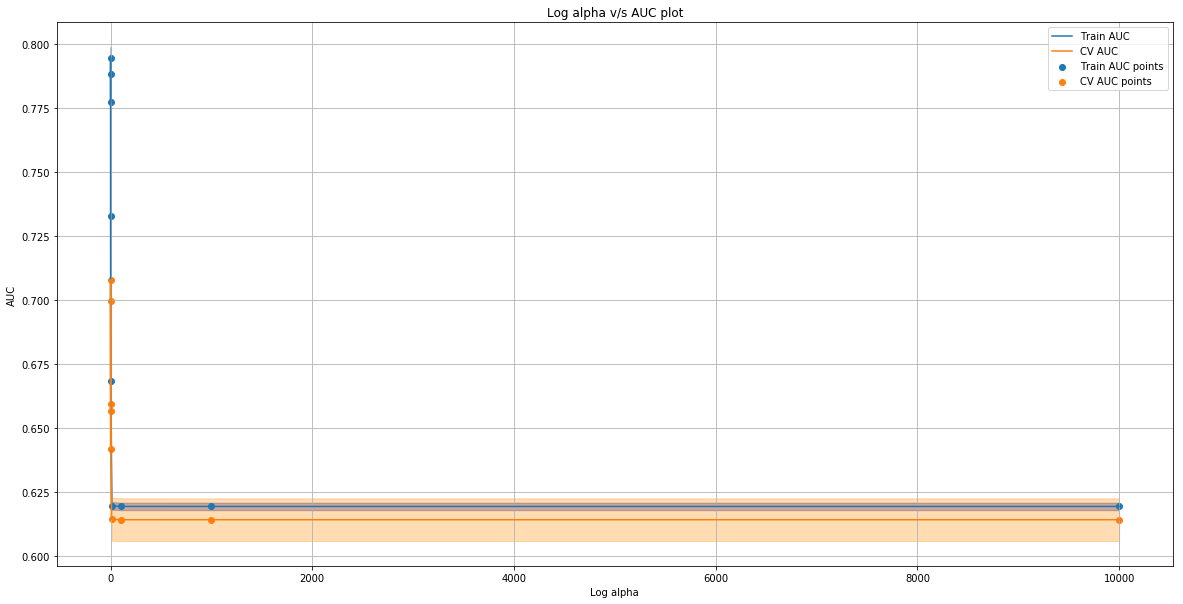

In [99]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc',return_train_score=True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

###### Summary - From the above plot, we can not determine the best hyperparameter value, so we need to take small set of alpha values.

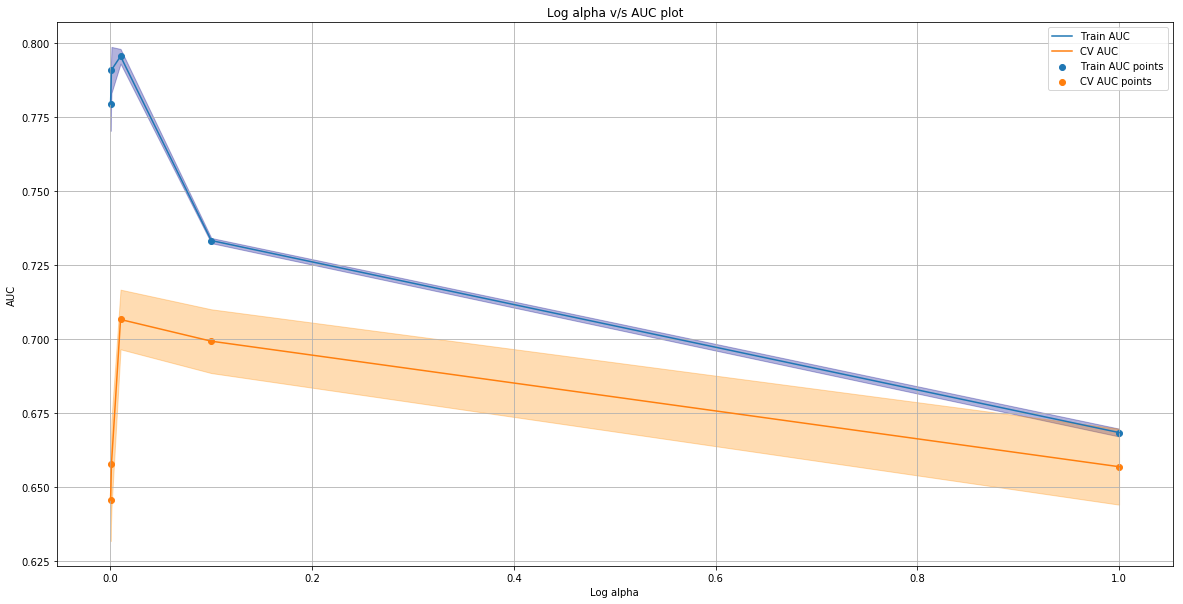

In [100]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I could not deter a suitable value for my parameter. So, on a smaller set of parameter values, I have re-run the GridSearchCV. I was able to restrict myself to a range of alpha values that could yield the expected result.

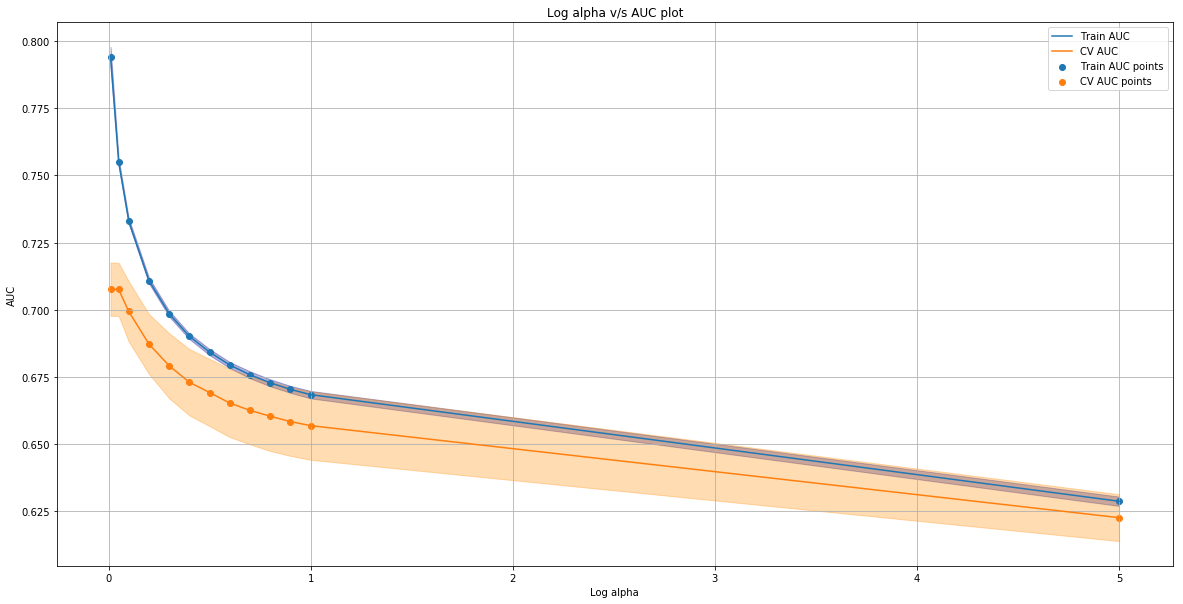

In [101]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - 0.5 The best value of the hyperparameter is selected. The AUC values after 0.1 appear to be lower for parameters / points. While there seems to be a significant difference between the Train model and the Test model for 0.1. So, consideration is given to 0.5.

## B) GridSearch using penalty=l1

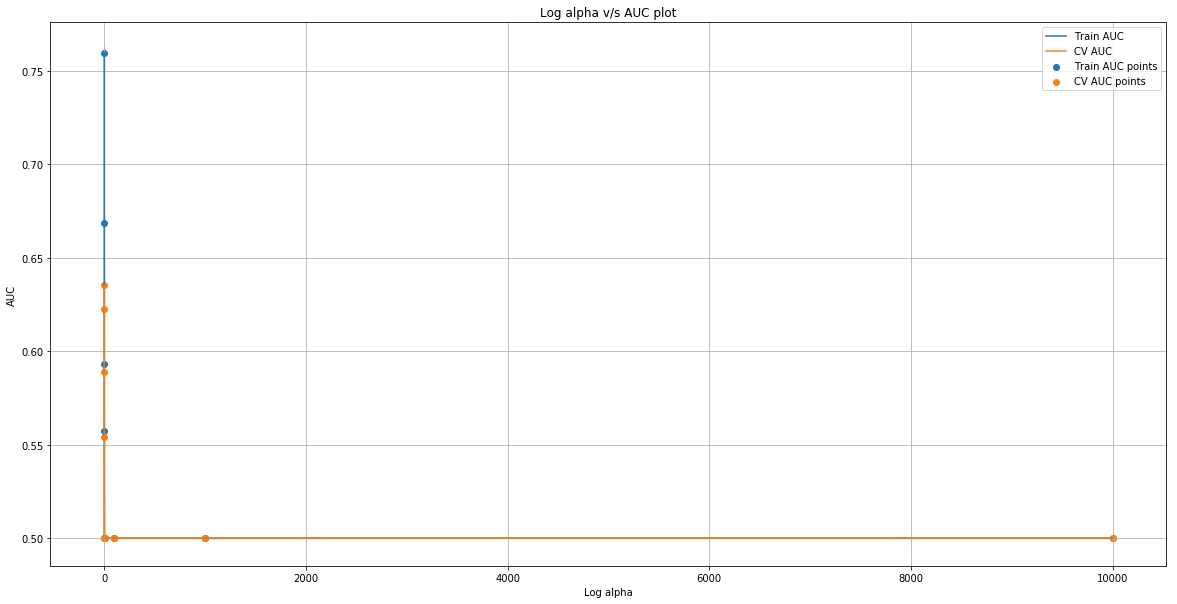

In [102]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - From the above plot, we can not determine the best hyperparameter value, so we need to take small set of alpha values.

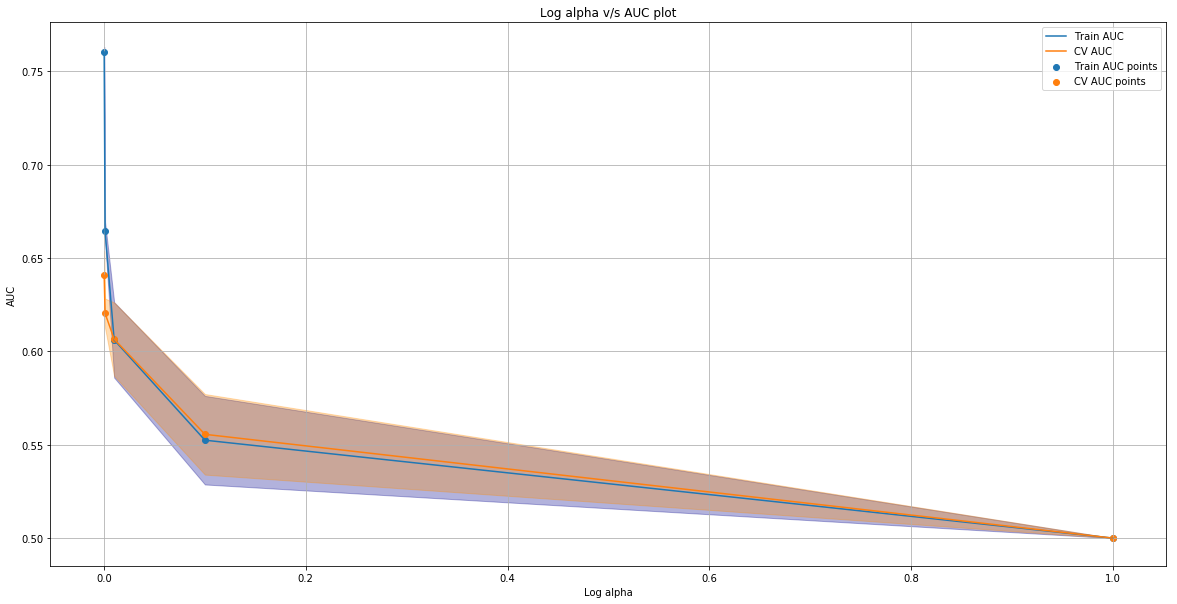

In [103]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a suitable value for my parameter, so I re-run the GridSearchCV on a smaller set of parameter values.

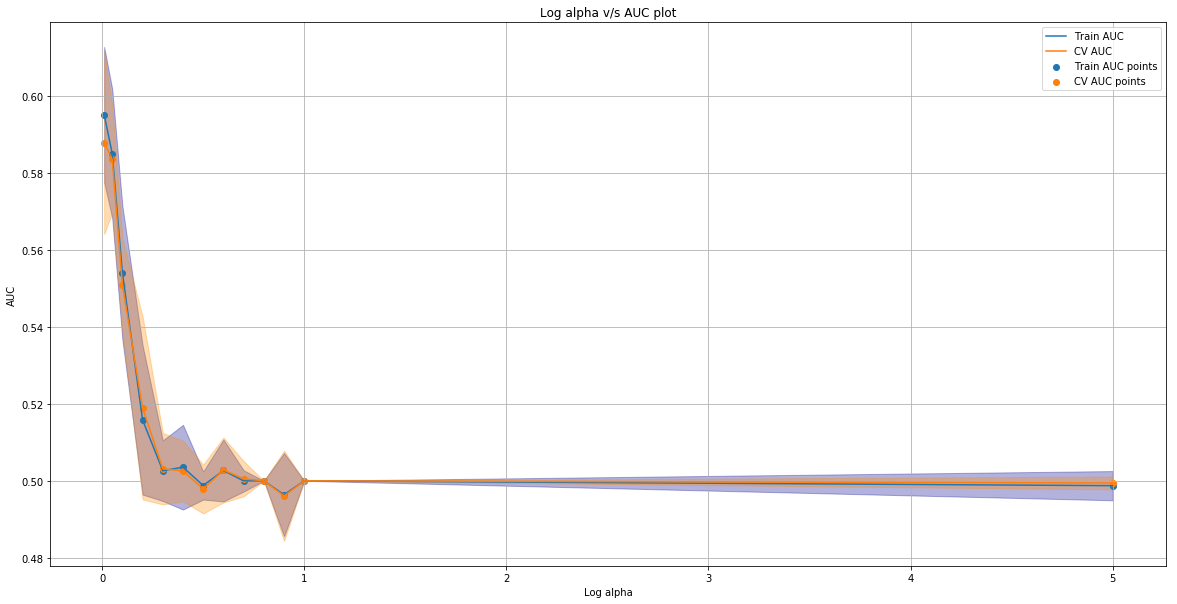

In [104]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()


##### Summary - I couldn't deter a suitable value for hyper parameter. L1 regularization produces a comparatively reduced AUC rating and the range appears to be thinner, making choosing an suitable value hard.

## C) Train the model using the best hyper parameter value

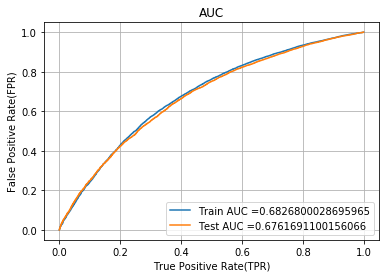

In [105]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.5, fit_intercept=True, class_weight='balanced')

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## C) Confusion matrix

In [106]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#### Train data

In [107]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold -0.14
[[ 3713  3713]
 [ 9908 31707]]


In [108]:
conf_matr_df_train_1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.25 for threshold -0.14


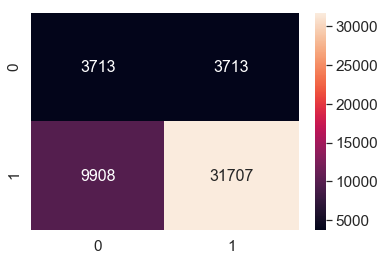

In [109]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_1, annot=True,annot_kws={"size": 16}, fmt='g')

#### Test data

In [110]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 0.03
[[ 3494  1965]
 [11533 19060]]


In [111]:
conf_matr_df_test_1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 0.03


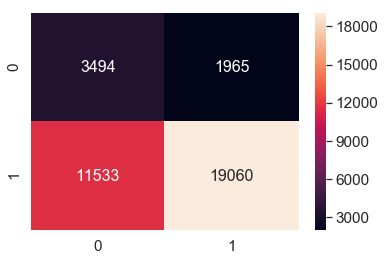

In [112]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_1, annot=True,annot_kws={"size": 16}, fmt='g')

## Set 2 : Categorical, Numerical features + Project_title(TFIDF) + Preprocessed_essay (TFIDF with min_df=10)

In [113]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, title_tfidf_train, text_tfidf_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, title_tfidf_test, text_tfidf_test)).tocsr()
X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, title_tfidf_cv, text_tfidf_cv)).tocsr()


In [114]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 14349) (49041,)
(24155, 14349) (24155,)
(36052, 14349) (36052,)


## A) GridSearch using penalty l2

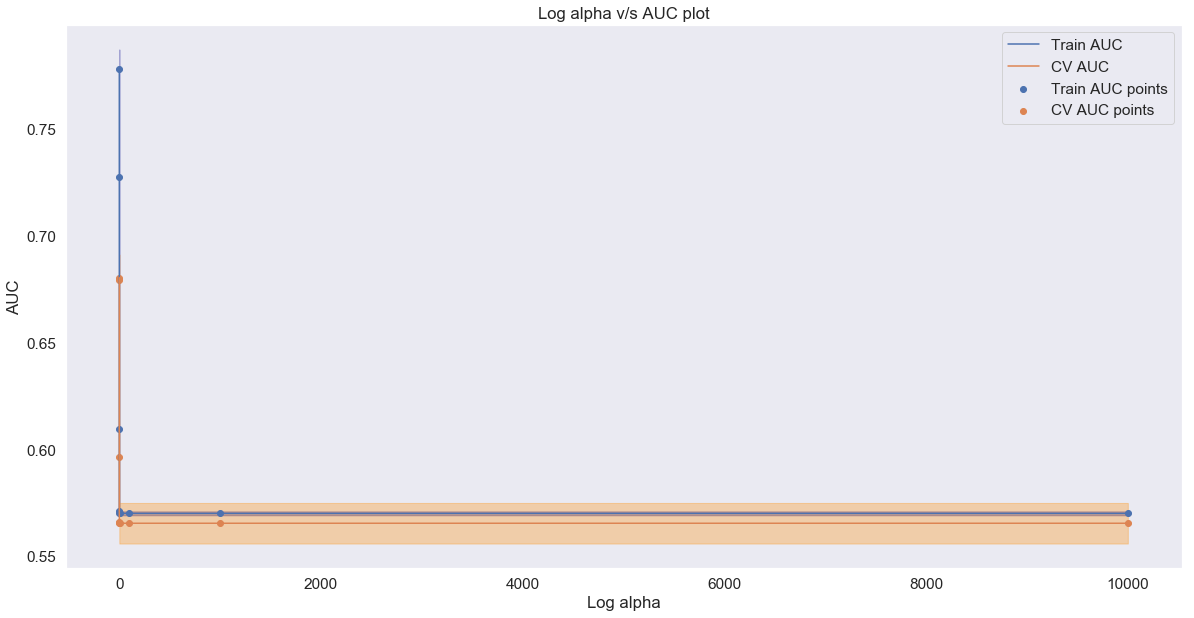

In [115]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - From the above plot, we can not determine the best hyperparameter value, so we need to take small set of alpha values.


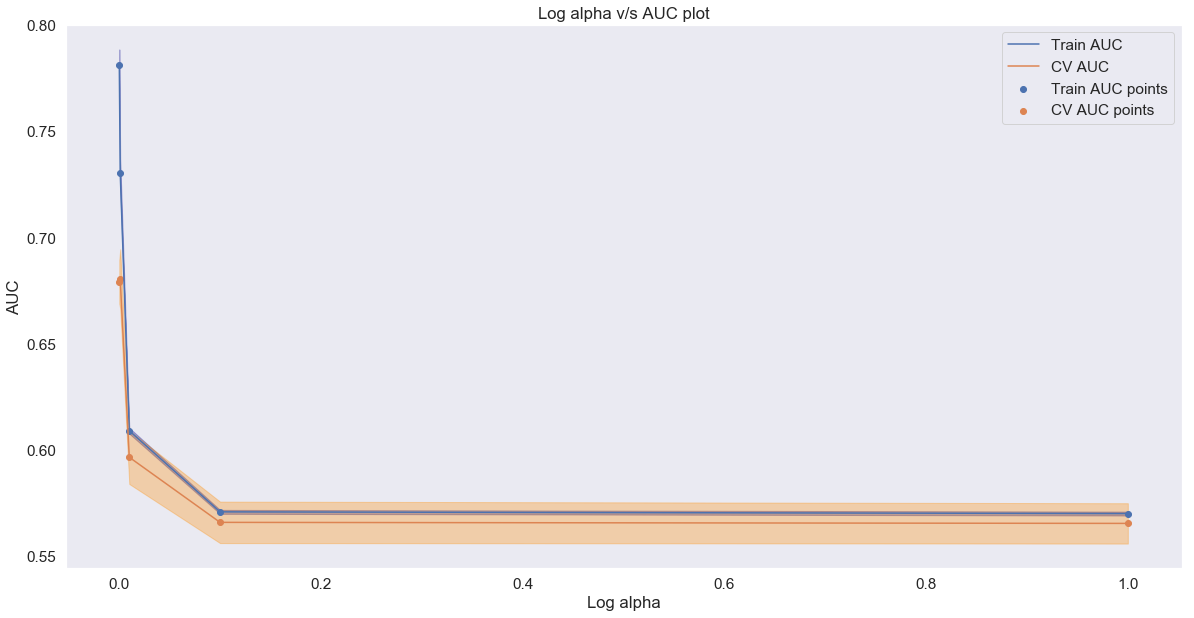

In [116]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a suitable value for my parameter, so I re-run the GridSearchCV on a smaller set of parameter values.

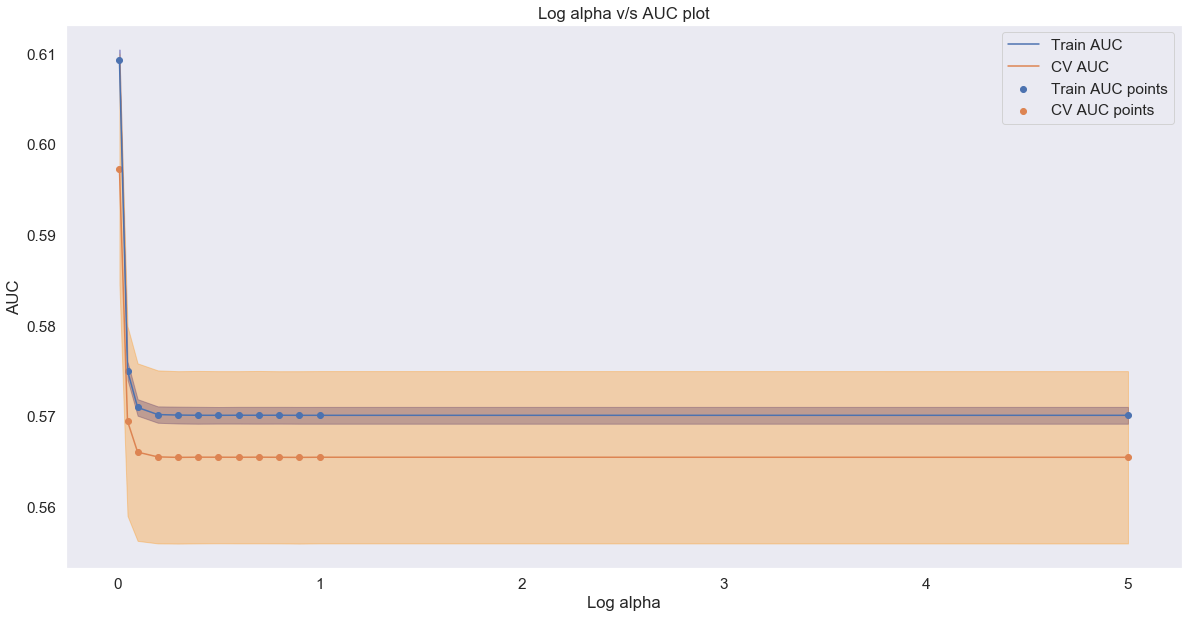

In [117]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - The parameter / point AUC values after 0.1 appear to be smaller. While a significant distinction seems to exist between the Train and the Test model for 0.1. Points under 0.2 had a reduced AUC score, nearly 0.4.

## GridSearchCV using penalty l1

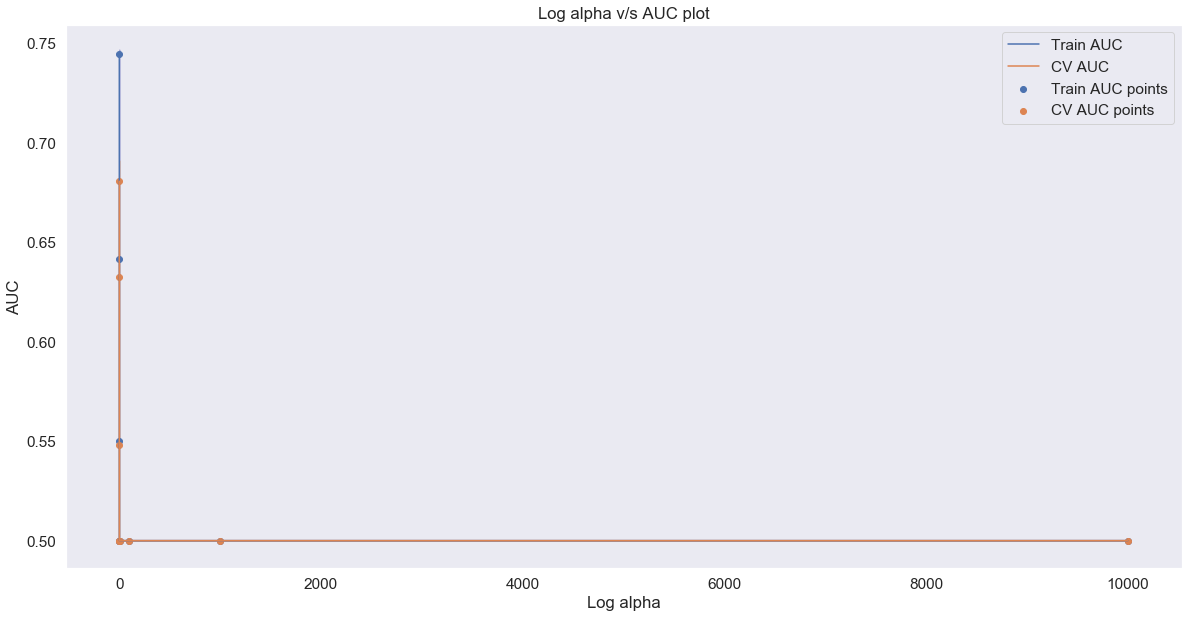

In [118]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a suitable value for my parameter. So, on a narrower set of parameter values, I re-run the GridSearchCV.

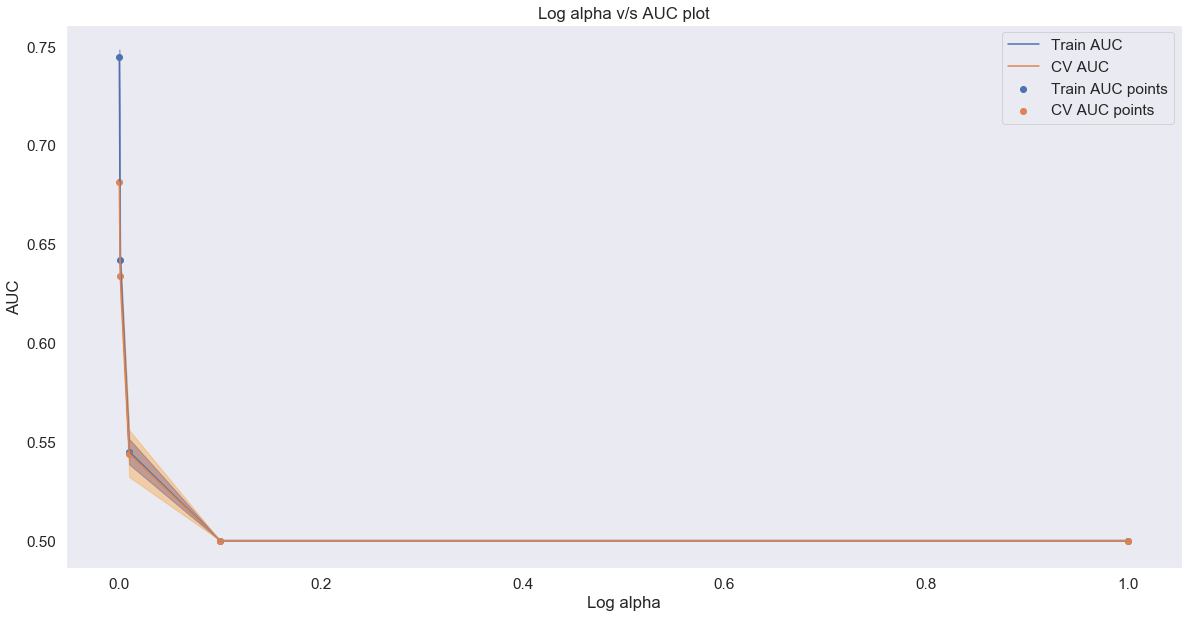

In [119]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a suitable value for my parameter. I re-run the GridSearchCV on a narrower set of parameter values.

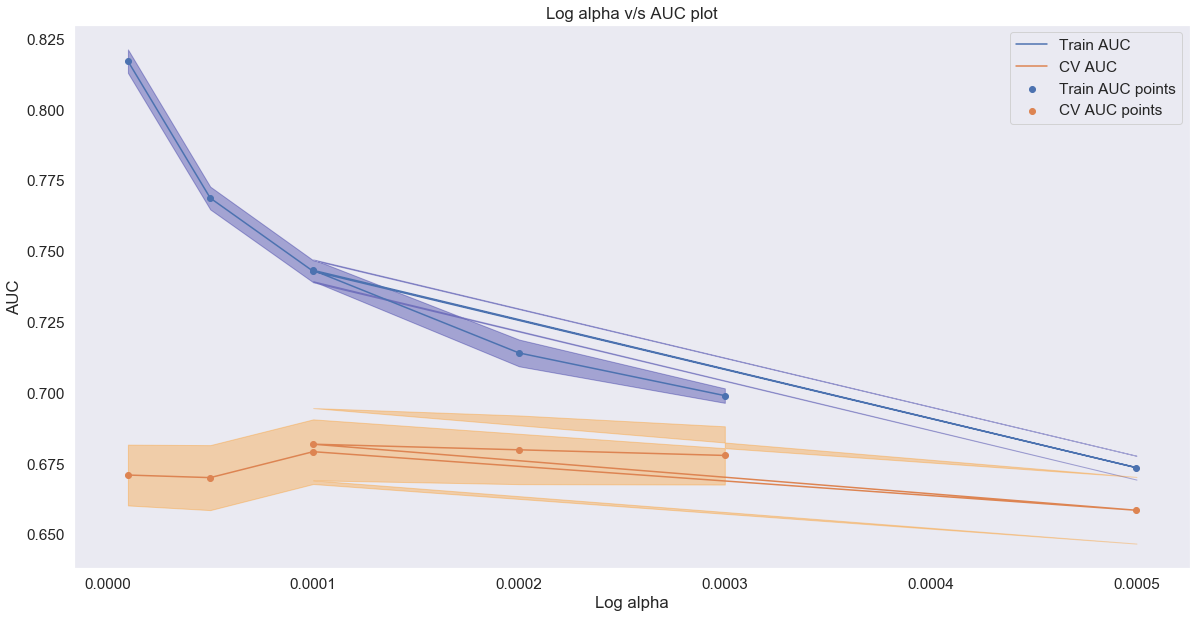

In [120]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[0.00001,0.00005,0.0001, 0.0005, 0.0001, 0.0002, 0.0003]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - For this hyperparameter, 0.0001 has been selected as the appropriate value. L1 Regularization in comparison with L2 Regularization seems to yield better parameter value. The AUC scores after 0.0001 are low for the points. For values below 0.0001, the difference between the train and the test model is high

## C) Train the model using the best hyperparameter value

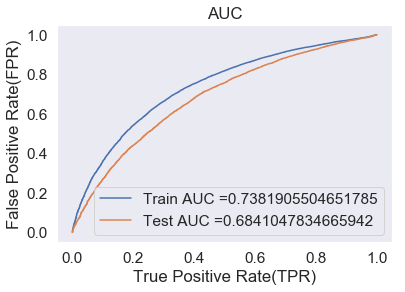

In [121]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001, fit_intercept=True, class_weight='balanced')

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## D) Confusion matrix

##### Train data

In [122]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold -0.442
[[ 3713  3713]
 [ 7601 34014]]


In [123]:
conf_matr_df_train_2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.25 for threshold -0.442


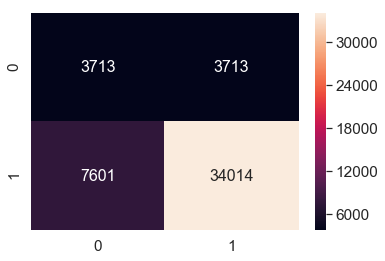

In [124]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_2, annot=True,annot_kws={"size": 16}, fmt='g')

##### Test data

In [125]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold -0.035
[[ 3134  2325]
 [ 9049 21544]]


In [126]:
conf_matr_df_test_2 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold -0.035


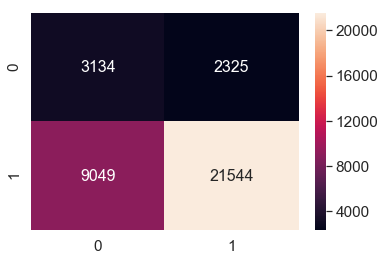

In [127]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_2, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 3 : Categorical, Numerical features + Project_title(AVG W2V) + Preprocessed_essay (AVG W2V)

In [128]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, avg_w2v_vectors_train, avg_w2v_vectors_titles_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, avg_w2v_vectors_test, avg_w2v_vectors_titles_test)).tocsr()
X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, avg_w2v_vectors_cv, avg_w2v_vectors_titles_cv)).tocsr()


In [129]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 709) (49041,)
(24155, 709) (24155,)
(36052, 709) (36052,)


## A) GridSearch CV

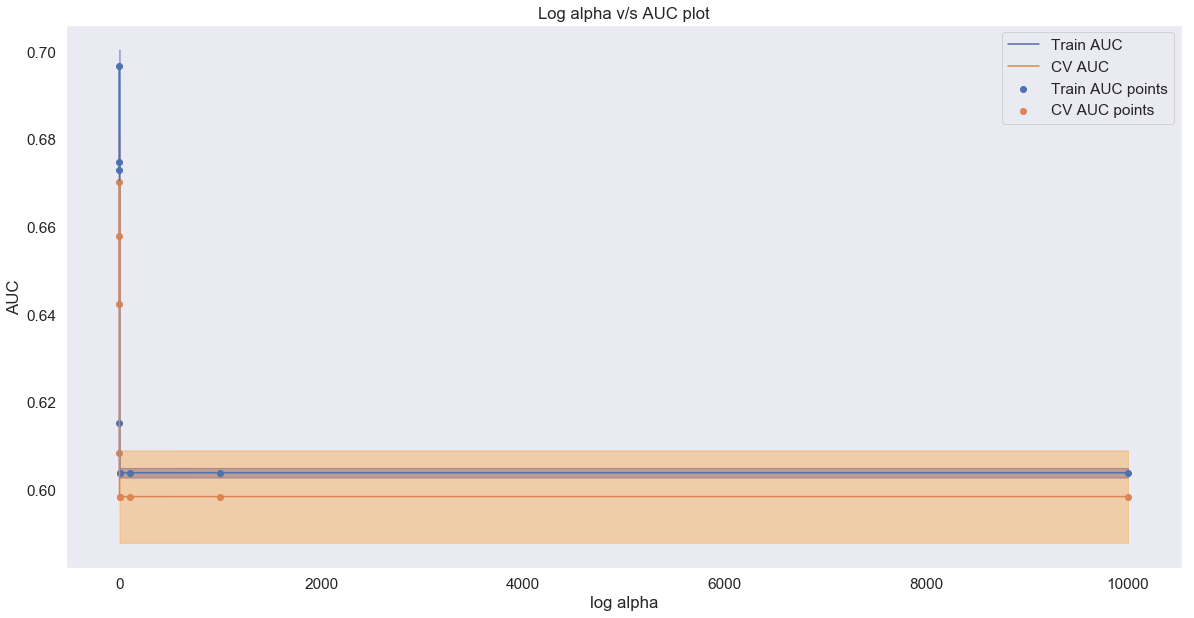

In [130]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a suitable value for this hyper parameter. So, on a narrower set of parameter values, I re-run the GridSearchCV. I was able to limit myself to a range of alpha values which could yield the expected result. Values in the 10 ^-4, 10 ^-3 & 10 ^-2 range had a significant difference in the Train and Cross Validation AUC scores. Values between 10 ^-2 and 10 ^-1 are more likely to be the suitable hyperparameter value. While the values above 10 ^-1 have a relatively small AUC rating. So, I'm going to look at values from 10 ^ -3 to 10 ^ -1.

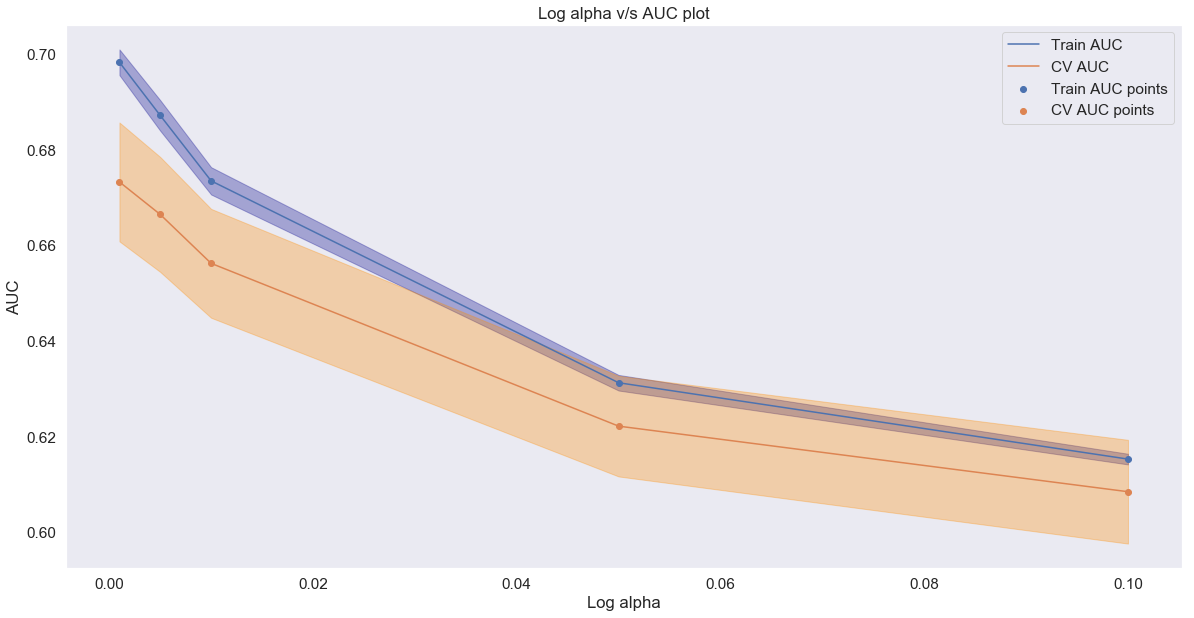

In [131]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[0.001, 0.005, 0.01, 0.05, 0.1]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - 0.005 is regarded the highest value because there is a lower AUC score after and before the points. There is also a comparable distinction between train and cross validation information, the model tends to perform better and comparable

## B) GridSearchCV using penalty l1

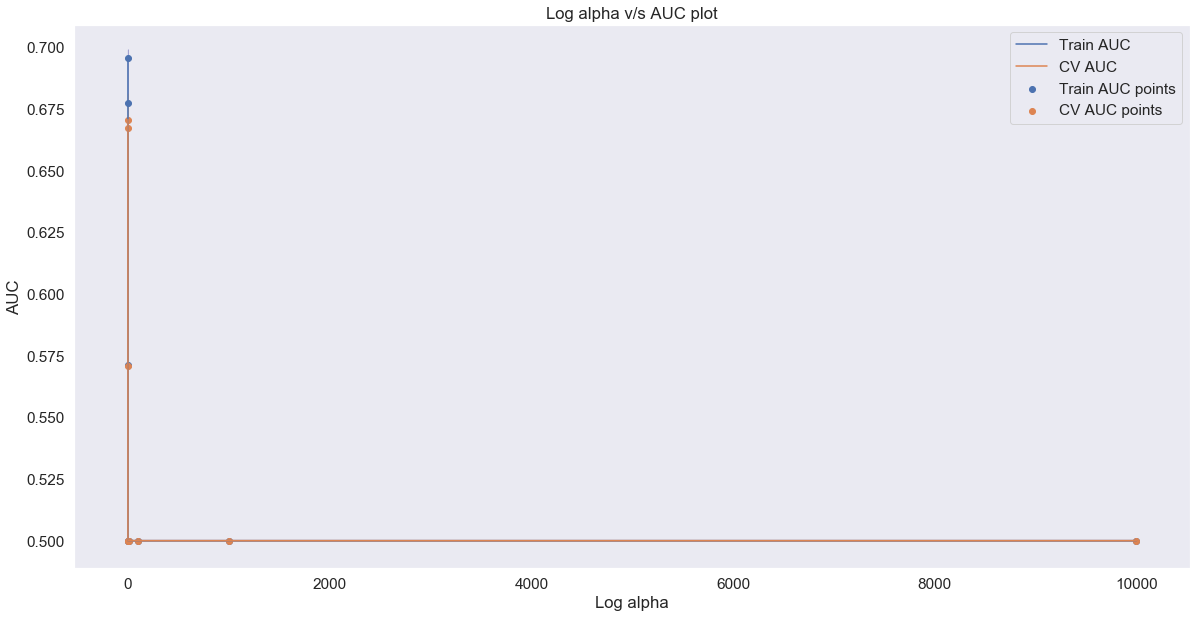

In [132]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a suitable value for my parameter. So, on a narrower set of parameter values, I re-run the GridSearchCV. I was able to restrict myself to a range of alpha values that could yield the expected result. Values in the 10 ^-4 to 10 ^-3 range as an alpha value have a stronger AUC rating and a smaller difference in AUC values.

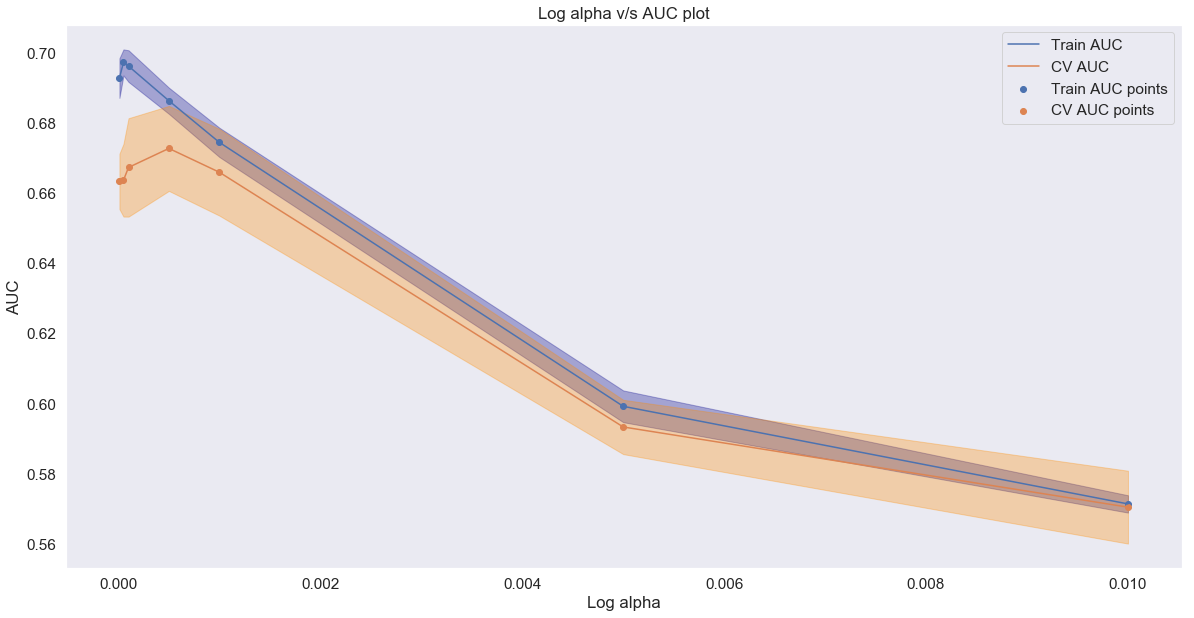

In [133]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - For this hyper parameter, I was unable to deter a suitable value. I re-run the GridSearchCV on a smaller set of values for parameters. I was able to limit myself to a range of alpha values which could yield the expected result.

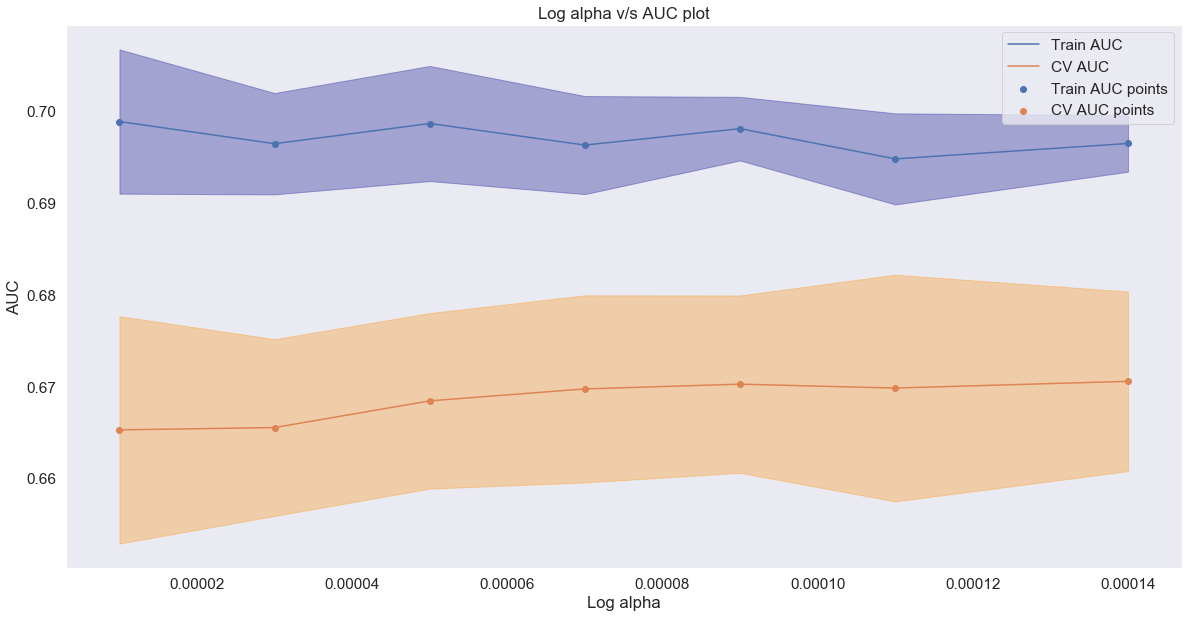

In [134]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight="balanced")

parameters = {'alpha':[0.00001, 0.00003, 0.00005, 0.00007, 0.00009, 0.00011, 0.00014]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - Values ranging from 0.00005 to 0.00011 had nearly comparable AUC scores and comparable differences in AUC results for test and cross validation. I selected 0.00005. Both l1 and l2 regularization perform equally.

## C) Train the model using the best hyperparameter value l2

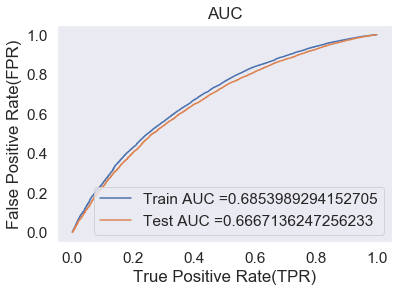

In [135]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.005, fit_intercept=True, class_weight='balanced')

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## D) Confusion matrix l2

##### Train data

In [136]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999818661462 for threshold 0.453
[[ 3714  3712]
 [ 9875 31740]]


In [137]:
conf_matr_df_train_3 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999818661462 for threshold 0.453


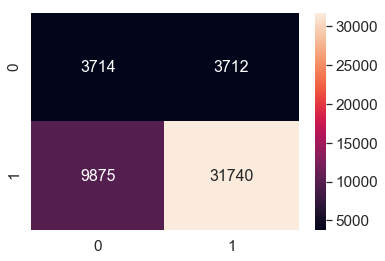

In [138]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_3, annot=True,annot_kws={"size": 16}, fmt='g')

##### Test data

In [139]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 0.714
[[ 3410  2049]
 [11536 19057]]


In [140]:
conf_matr_df_test_3 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 0.714


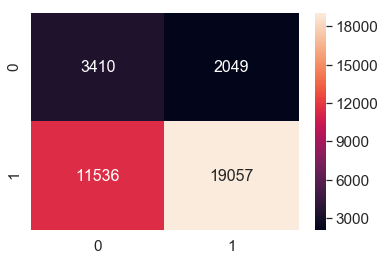

In [141]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_3, annot=True,annot_kws={"size": 16}, fmt='g')

## E) Train the model using the best hyper parameter value l1

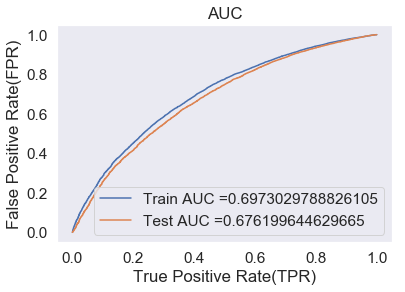

In [142]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l1', alpha=0.00005, fit_intercept=True, class_weight='balanced')

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

### F) Confusion matrix l1

##### Train data

In [143]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold -0.878
[[ 3713  3713]
 [ 9393 32222]]


In [144]:
conf_matr_df_train_3_l1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.25 for threshold -0.878


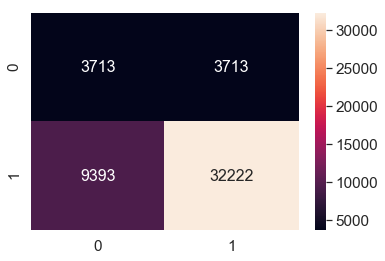

In [145]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_3_l1, annot=True,annot_kws={"size": 16}, fmt='g')

##### Test data

In [146]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.211
[[ 3349  2110]
 [10912 19681]]


In [147]:
conf_matr_df_test_3_l1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.211


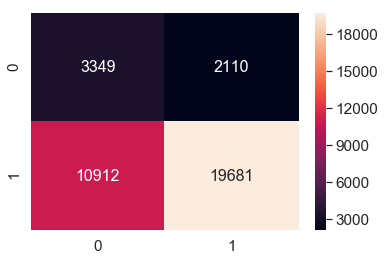

In [148]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_3_l1, annot=True,annot_kws={"size": 16}, fmt='g')


# Set 4 : Categorical, Numerical features + Project_title(TFIDF W2V) + Preprocessed_essay (TFIDF W2V)

In [149]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, tfidf_w2v_vectors_train, tfidf_w2v_vectors_titles_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, tfidf_w2v_vectors_test, tfidf_w2v_vectors_titles_test)).tocsr()
X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, tfidf_w2v_vectors_cv, tfidf_w2v_vectors_titles_cv)).tocsr()


In [150]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 709) (49041,)
(24155, 709) (24155,)
(36052, 709) (36052,)


## A) GridSearch CV using penalty l2

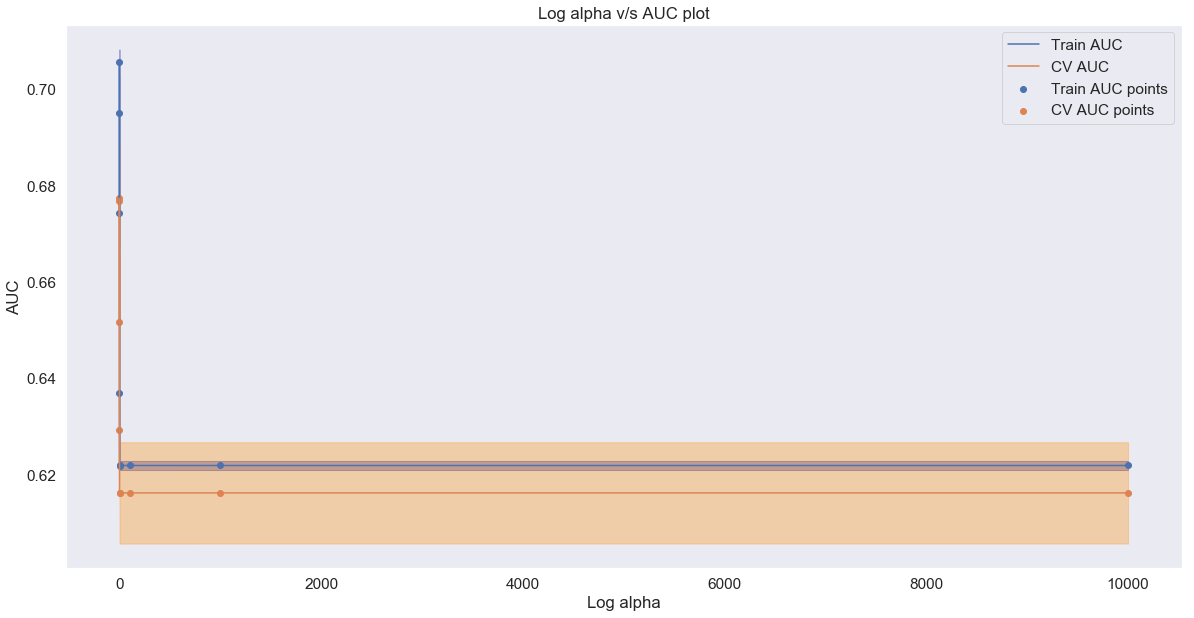

In [151]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a proper value for my parameter. So, on a narrower set of parameter values I re-run the GridSearchCV. I was able to narrow down to a range of alpha values that could produce the expected outcome.

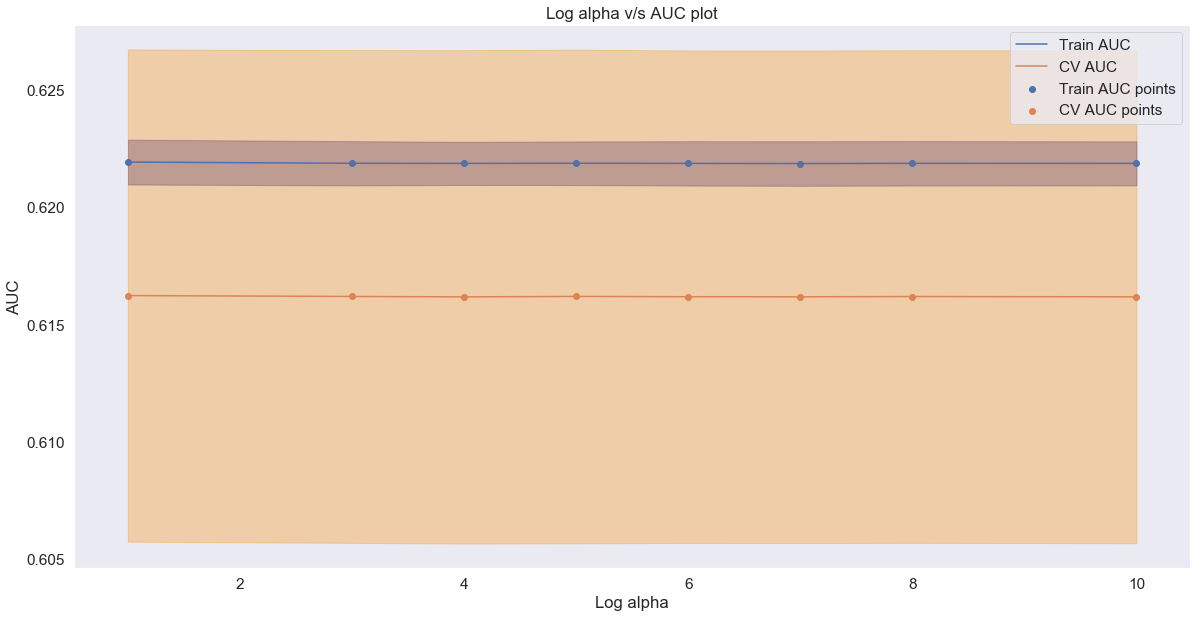

In [152]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[1, 3, 4, 5, 6, 7, 8, 10]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - Compared to the other hyperparameters, Alpha value 4 seems to be a better hyperparameter value. It has a stronger score and points of AUC before and after the AUC results are not comparable.

## GridSearchCV using the penalty l1

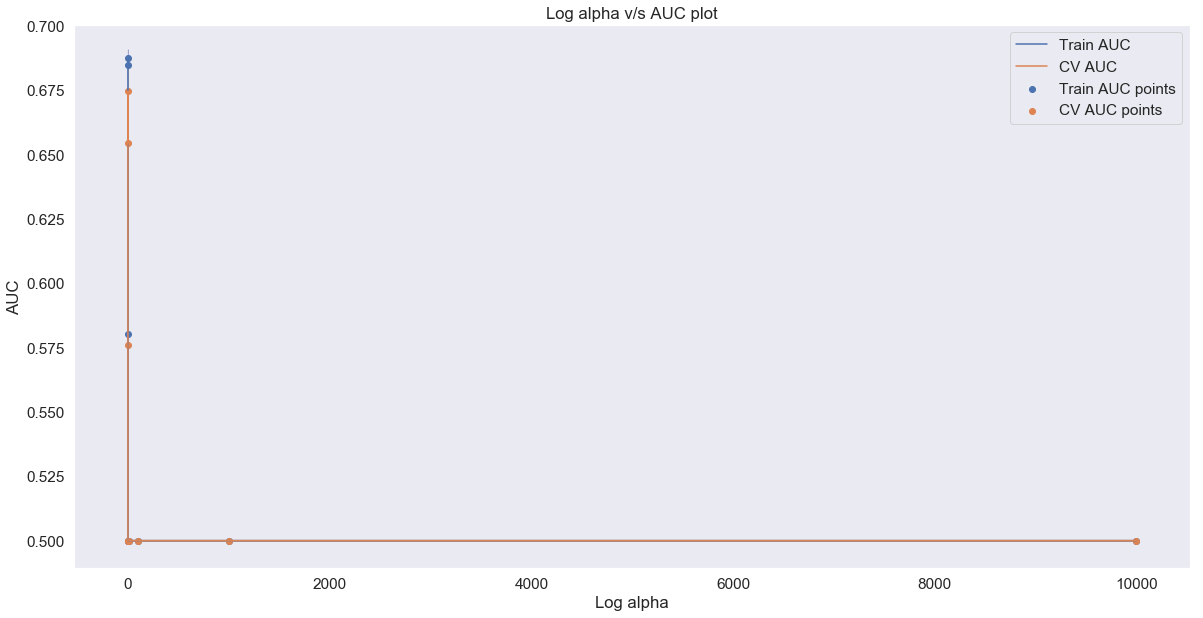

In [154]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I could not deter a suitable value for my parameter. So, on a smaller set of parameter values I have re-run the GridSearchCV. I was able to restrict myself to a range of alpha values that could yield the expected result.

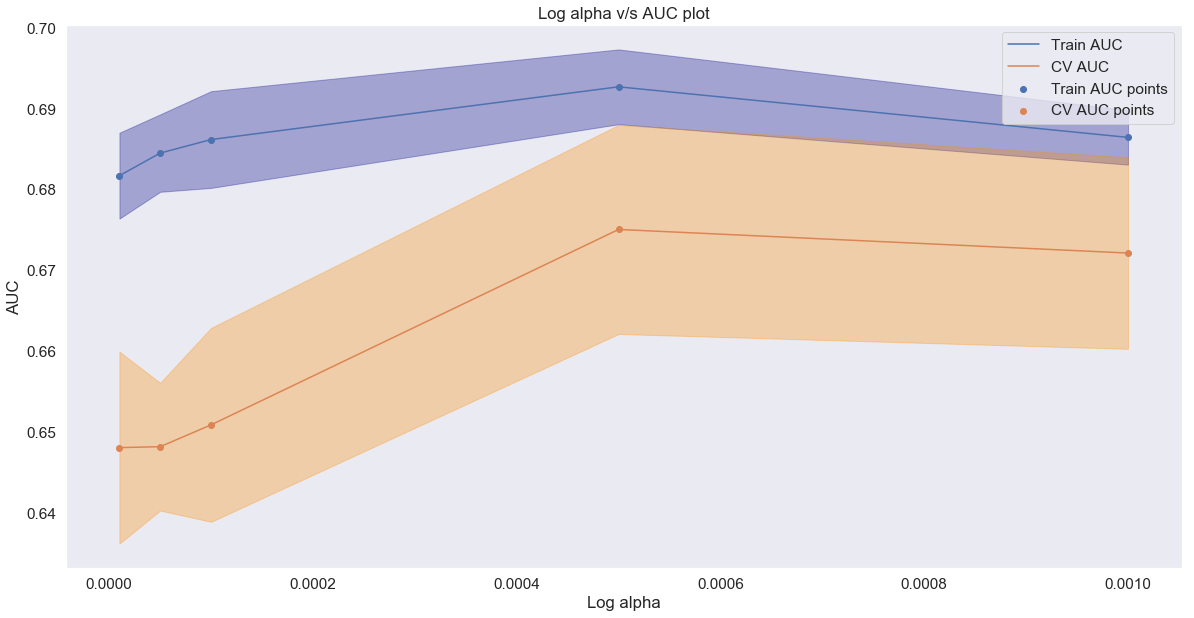

In [157]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc',return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - The Alpha value is regarded to be 0.0001.

## C) Train the model using the best hyper parameter value (L2)

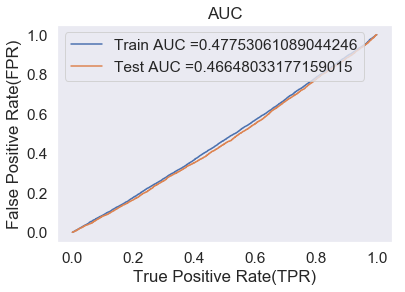

In [158]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l2', alpha= 4.0, fit_intercept=True, class_weight=None)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## D) Confusion Matrix (L2)

##### Train Data

In [159]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 1.037
[[ 3713  3713]
 [22153 19462]]


In [160]:
conf_matr_df_train_4_l2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.25 for threshold 1.037


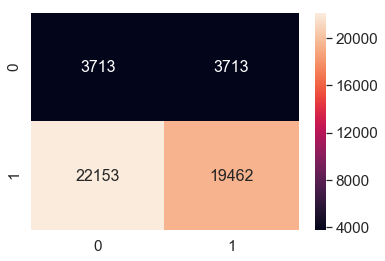

In [161]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_4_l2, annot=True,annot_kws={"size": 16}, fmt='g')

##### Test Data

In [162]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold 1.059
[[ 3273  2186]
 [19814 10779]]


In [163]:
conf_matr_df_test_4_l2 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold 1.059


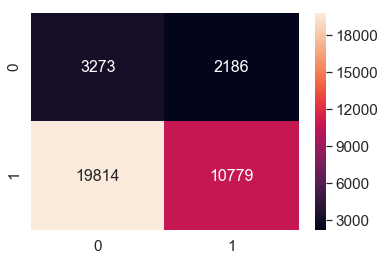

In [164]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_4_l2, annot=True,annot_kws={"size": 16}, fmt='g')

## E) Train the model using the best hyperparameter value l1

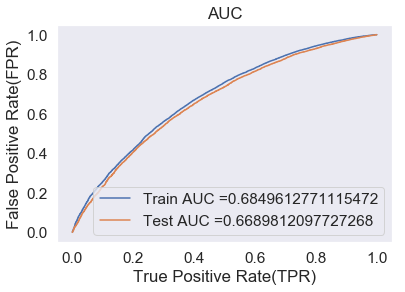

In [165]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001, fit_intercept=True, class_weight=None)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()


## F) Confusion matrix l1

##### Train data

In [166]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999818661462 for threshold 2.538
[[ 3714  3712]
 [10049 31566]]


In [167]:
conf_matr_df_train_4 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999818661462 for threshold 2.538


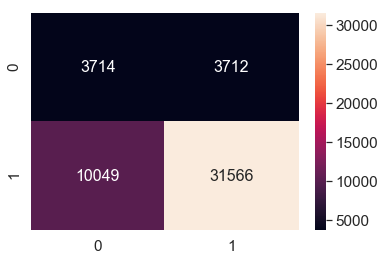

In [168]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_4, annot=True,annot_kws={"size": 16}, fmt='g')

##### Test data

In [169]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 2.775
[[ 3427  2032]
 [11610 18983]]


In [170]:
conf_matr_df_test_4 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 2.775


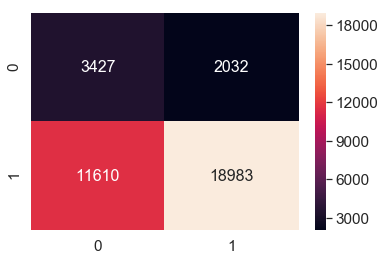

In [171]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_4, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 5 : Categorical features, Numerical features by TruncatedSVD on TfidfVectorizer

## A) Using Elbow method to narrow down the best number of Components

In [172]:
text_tfidf_train.shape

(49041, 12138)

In [173]:
from sklearn.decomposition import TruncatedSVD

index = [5,10,50,100,250,500,1000,2000, 3000, 4000, 5000]
variance_sum = []

for i in tqdm(index):
    svd = TruncatedSVD(n_components= i, n_iter=7, random_state=42)
    svd.fit(text_tfidf_train)
    variance_sum.append(svd.explained_variance_ratio_.sum())

100%|███████████████████████████████████████| 11/11 [1:08:11<00:00, 957.46s/it]


In [174]:
index = [5,10,50,100,250,500,1000,2000, 3000, 4000, 5000]

In [175]:
variance_sum

[0.0334118814079747,
 0.05290396428760714,
 0.13157255750158864,
 0.18943881782401084,
 0.30260407549505197,
 0.4242791055573957,
 0.5729719700300394,
 0.7330795205875253,
 0.8218779864900914,
 0.8775573287115108,
 0.9147587106153354]

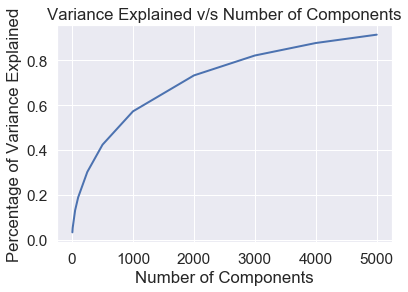

In [176]:
plt.xlabel("Number of Components")
plt.ylabel("Percentage of Variance Explained")
plt.title("Variance Explained v/s Number of Components")
plt.plot(index,variance_sum,lw=2)
plt.show()

In [177]:
print("Let us consider 5000 points as the number of Components. It Explains more than 90% of the Variance in the data")

Let us consider 5000 points as the number of Components. It Explains more than 90% of the Variance in the data


### Train data

In [178]:
svd = TruncatedSVD(n_components= 5000, n_iter=7, random_state=42)
svd.fit(text_tfidf_train)
svd_train = svd.transform(text_tfidf_train)

In [179]:
print("Shape of matrix after Decomposition ",svd_train.shape)

Shape of matrix after Decomposition  (49041, 5000)


### Test data

In [180]:
svd_test = svd.transform(text_tfidf_test)
print("Shape of matrix after Decomposition ",svd_test.shape)

Shape of matrix after Decomposition  (36052, 5000)


### CV data

In [181]:
svd_cv = svd.transform(text_tfidf_cv)
print("Shape of matrix after Decomposition ",svd_cv.shape)

Shape of matrix after Decomposition  (24155, 5000)


In [182]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_compound_train, svd_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_compound_test, svd_test)).tocsr()
X_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, essay_sent_pos_cv, essay_sent_neg_cv, essay_sent_neu_cv, essay_sent_compound_cv, svd_cv)).tocsr()


In [183]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 5109) (49041,)
(24155, 5109) (24155,)
(36052, 5109) (36052,)


## A) GridSearch CV using penalty l2

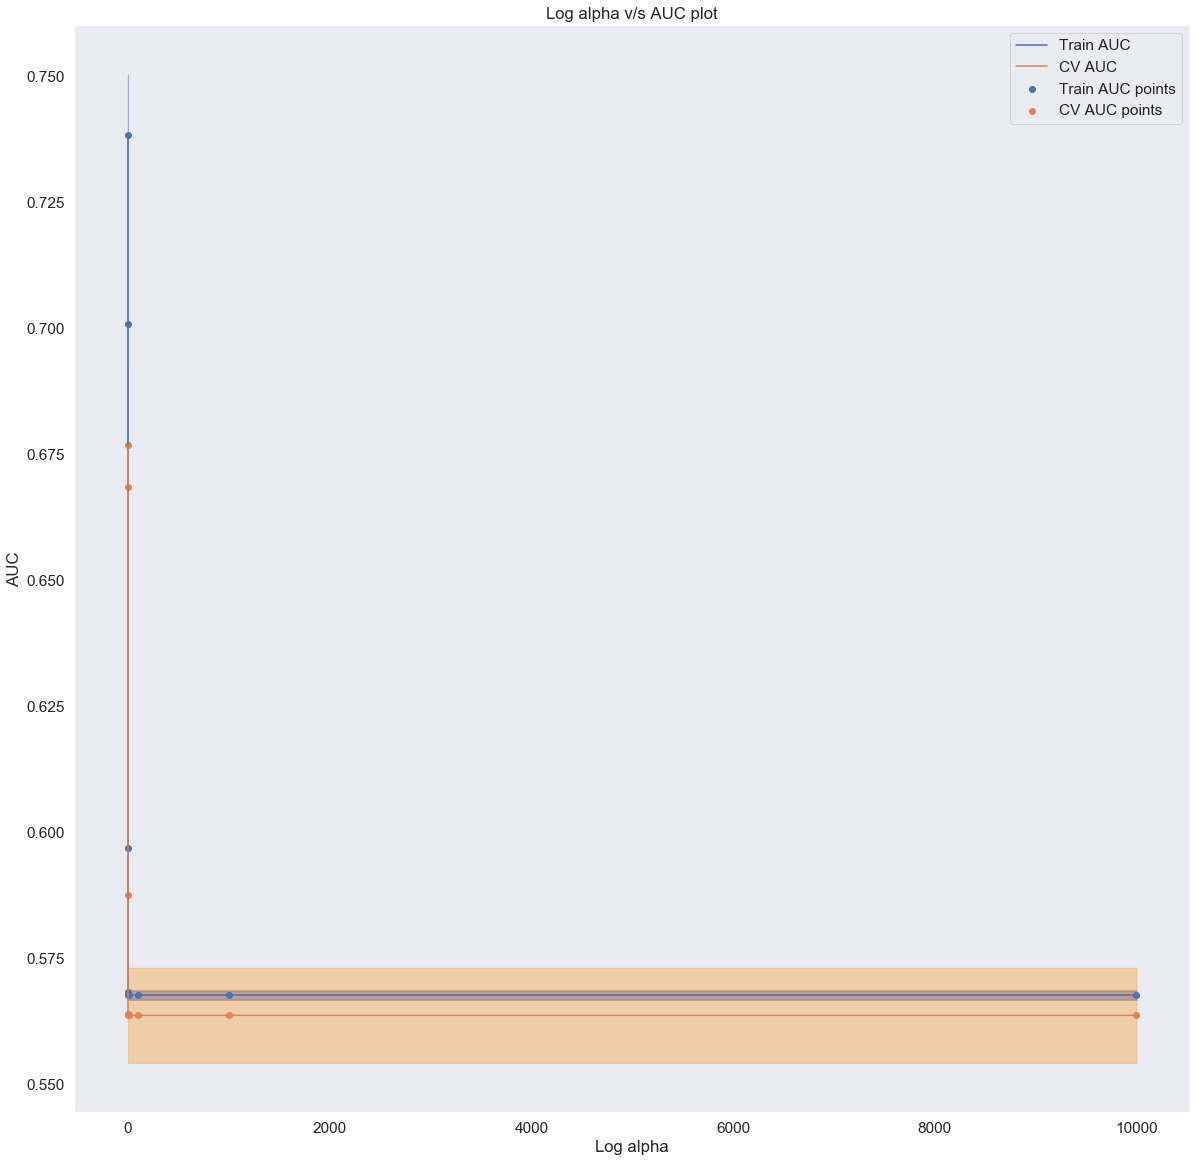

In [184]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight="balanced")

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values. I could narrow down to a range of alpha values that could produce the expected outcome. Alpha values between 0.1 and 1 appear to be an appropriate range.

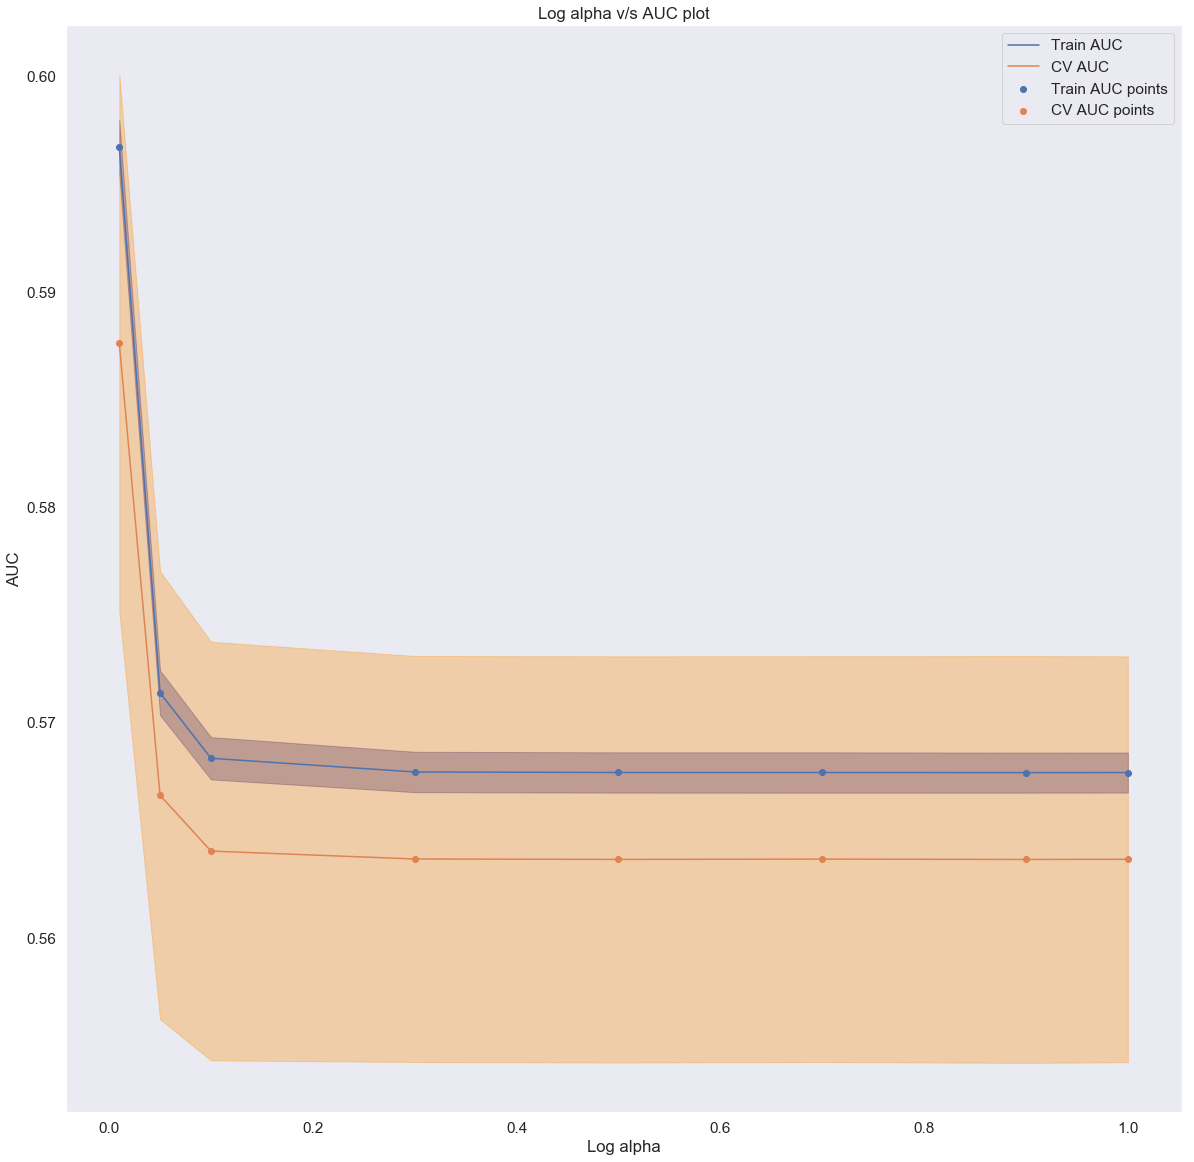

In [185]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight='balanced')

parameters = {'alpha':[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a proper value for my parameter. So, on a narrower set of parameter values I re-run the GridSearchCV. I was able to restrict myself to a range of alpha values that could yield the expected result. Alpha values in the 0.1 to 0.3 range appear to be an appropriate range.

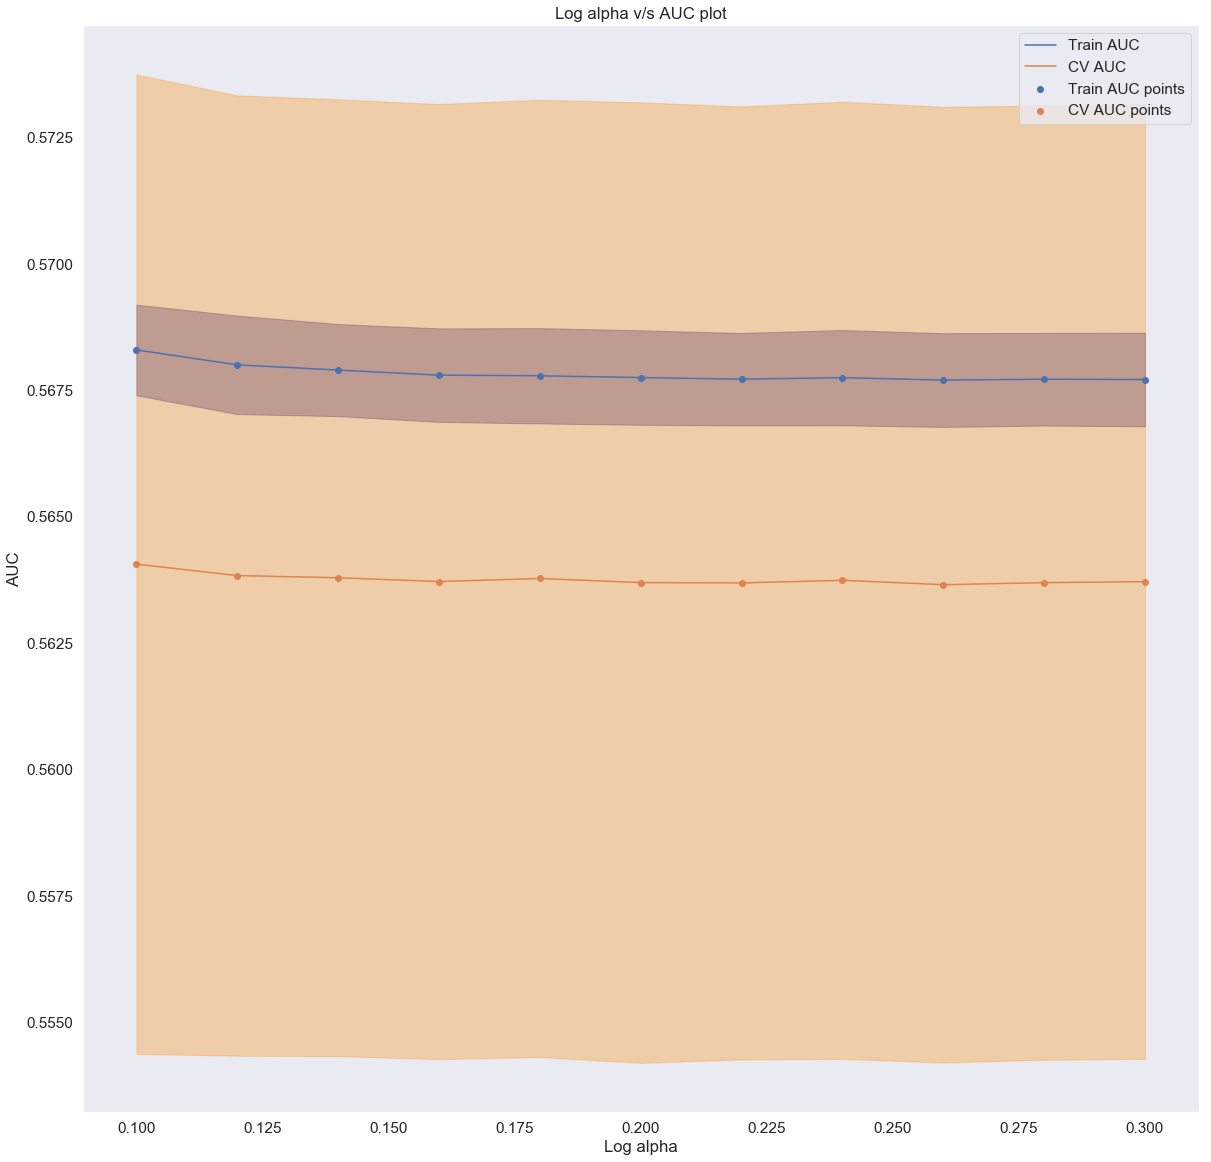

In [186]:
sv = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, class_weight="balanced")

parameters = {'alpha':[0.10, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - 0.18 can be considered as the alpha value.

## B) GridSearch CV using penalty l1

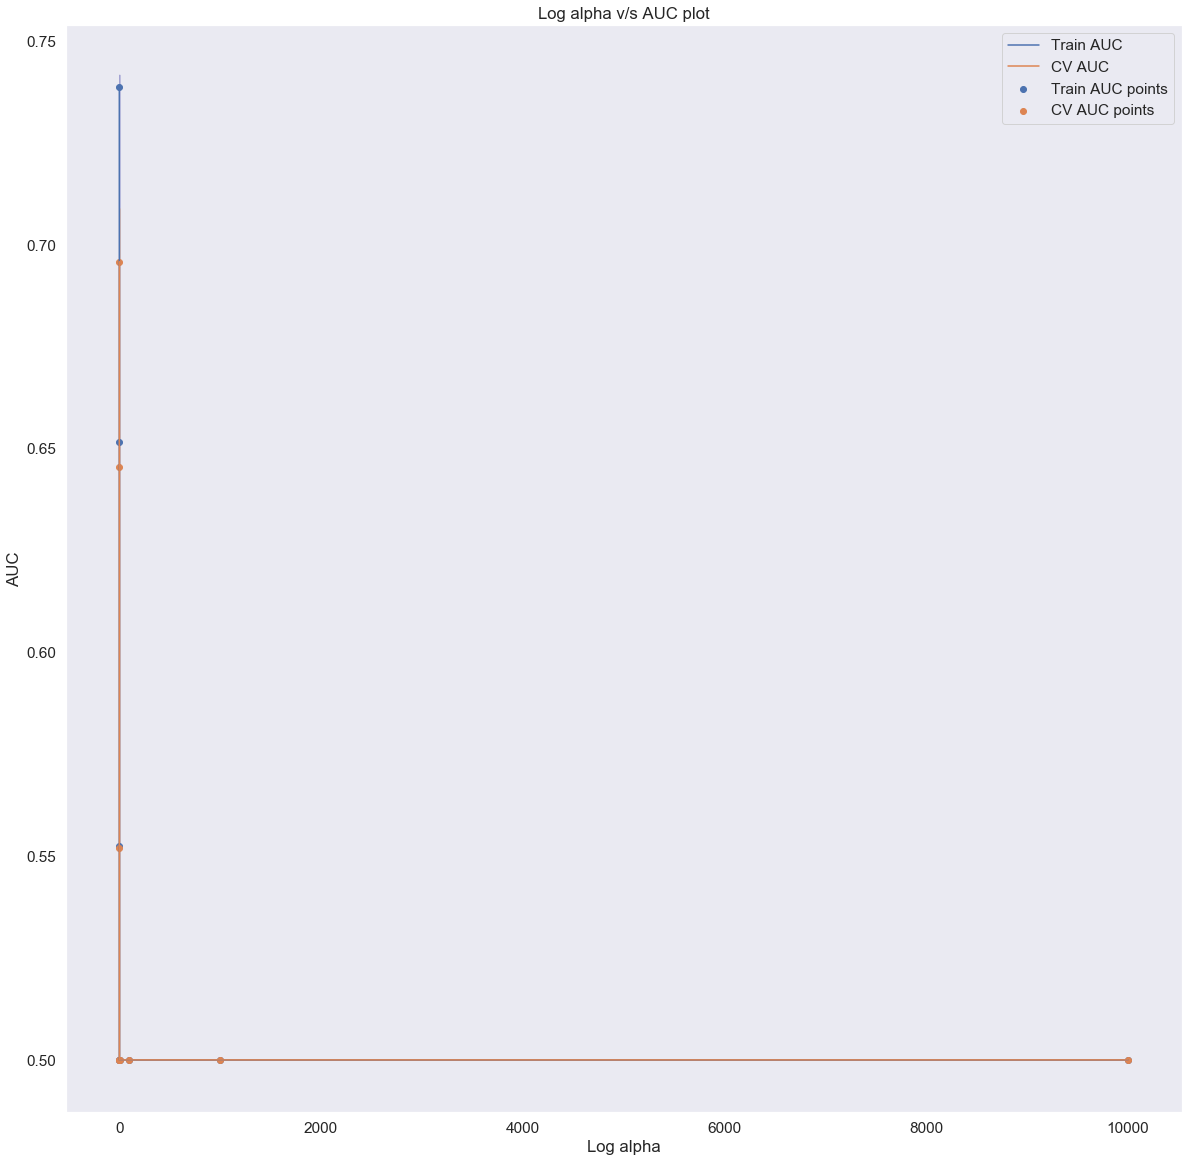

In [187]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight="balanced")

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - I couldn't deter a suitable value for my parameter. So, on a narrower set of parameter values, I re-run the GridSearchCV.  I could narrow down to a range of alpha values that could produce the expected outcome. Alpha values between 10 ^-4 and 10 ^-3 appear to be an appropriate range

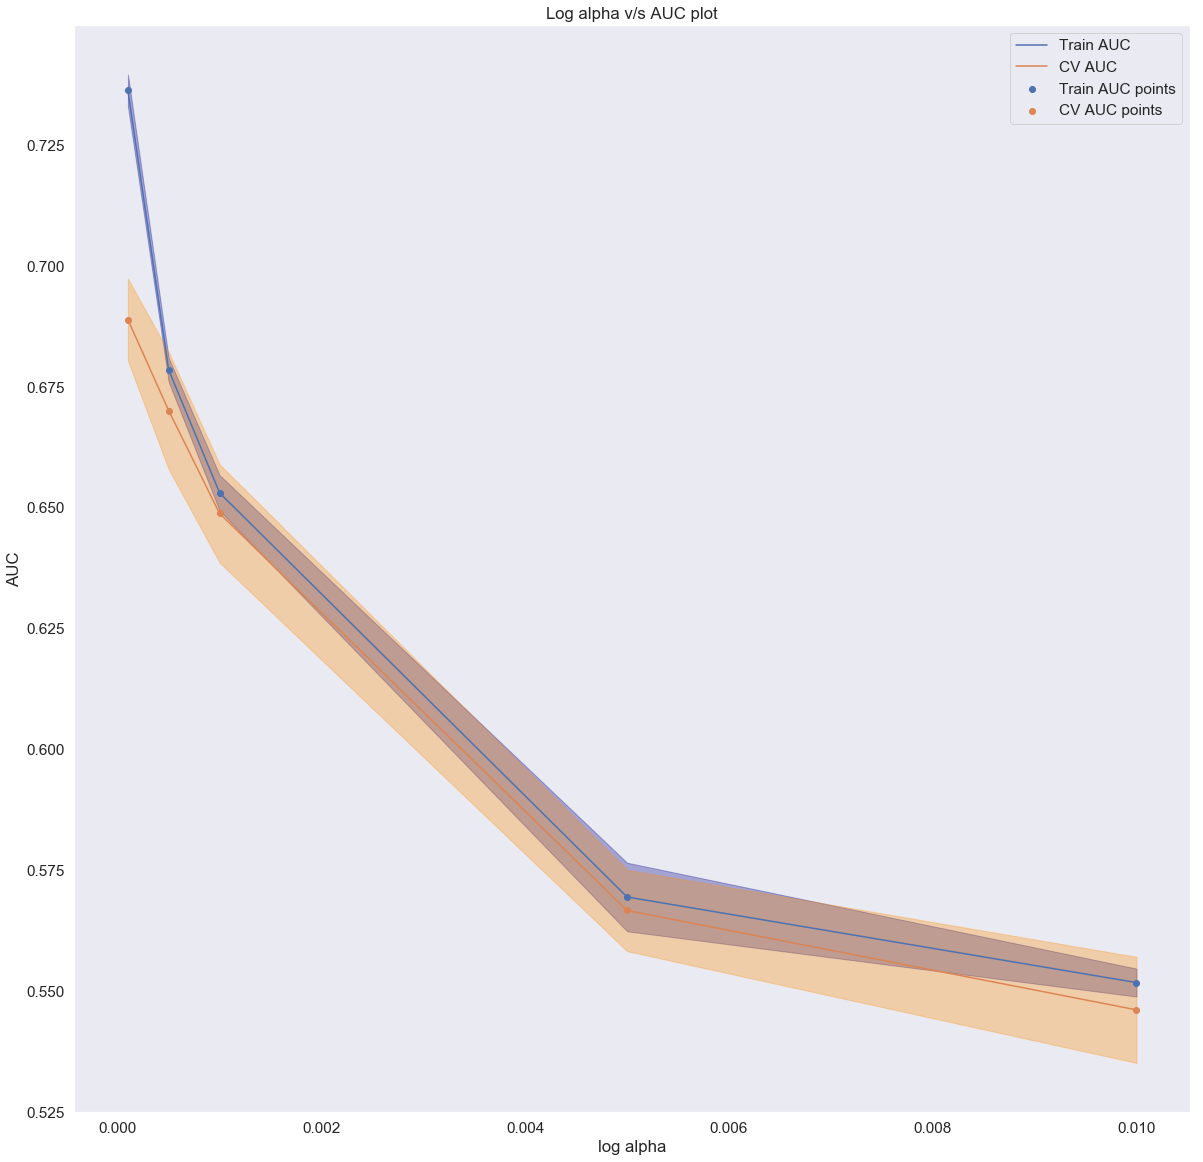

In [188]:
sv = SGDClassifier(loss='hinge', penalty='l1', fit_intercept=True, class_weight="balanced")

parameters = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc', return_train_score = True)

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log alpha")
plt.ylabel("AUC")
plt.title("Log alpha v/s AUC plot")
plt.grid()
plt.show()

##### Summary - 0.0001 can be considered as the alpha value.

## C) Train the model using the best hyperparameter l2

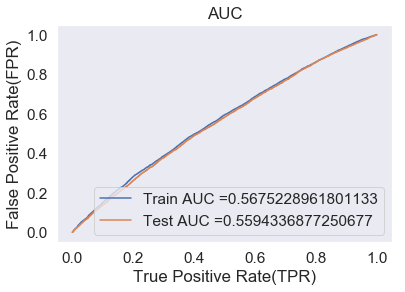

In [189]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l2', alpha= 0.18, fit_intercept=True, class_weight="balanced")

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## D) Confusion Matrix (L2)

##### Train Data

In [190]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.153
[[ 3713  3713]
 [16884 24731]]


In [191]:
conf_matr_df_train_5_l2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.25 for threshold 0.153


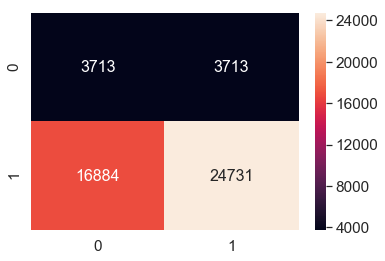

In [192]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_5_l2, annot=True,annot_kws={"size": 16}, fmt='g')

##### Test Data

In [193]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold 0.249
[[ 3454  2005]
 [16731 13862]]


In [194]:
conf_matr_df_test_5_l2 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold 0.249


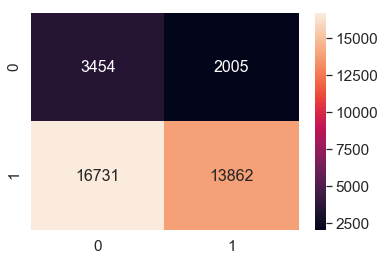

In [195]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_5_l2, annot=True,annot_kws={"size": 16}, fmt='g')

## E) Train the model using the best hyperparameter value l1

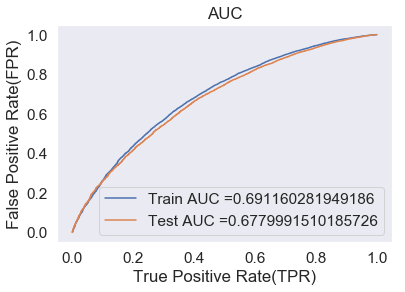

In [196]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l1', alpha= 0.0001, fit_intercept=True, class_weight=None)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## F) Confusion matrix l1

##### Train data

In [197]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999818661462 for threshold 1.134
[[ 3714  3712]
 [ 9708 31907]]


In [198]:
conf_matr_df_train_5_l1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999818661462 for threshold 1.134


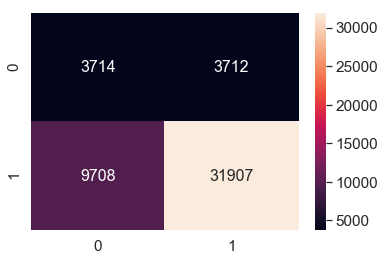

In [199]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_5_l1, annot=True,annot_kws={"size": 16}, fmt='g')

##### Test data

In [200]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.211
[[ 3438  2021]
 [11400 19193]]


In [201]:
conf_matr_df_test_5_l1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.211


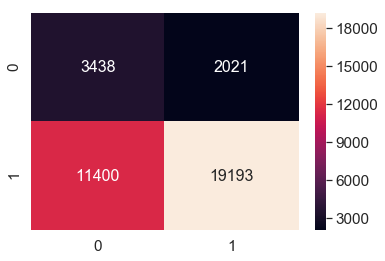

In [202]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_5_l1, annot=True,annot_kws={"size": 16}, fmt='g')

# 3) Conclusion

In [203]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Penalty","Alpha:Hyper Parameter", "AUC"]

x.add_row(["BOW", "Linear SVM","L2 performs better than L1", "0.5", "0.673"])
x.add_row(["TFIDF", "Linear SVM", "L1 performs better than L2","0.0001", "0.684"])
x.add_row(["AVG W2V", "Linear SVM", "L1 & L2 both have similar effects", "L1:0.00005 & L2:0.005", "L1:0.676 & L2:0.666"])
x.add_row(["TFIDF W2V", "Linear SVM", "Neither L1 or L2", "L1:0.0001 & L2:4.0", "L1:0.668 & L2:0.466"])
x.add_row(["TRUNCATED SVD", "Linear SVM", "L1 & L2 both have similar effects", "L1:0.0001 & L2:0.18", "L1:0.677 & L2:0.559"])


print(x)

+---------------+------------+-----------------------------------+-----------------------+---------------------+
|   Vectorizer  |   Model    |              Penalty              | Alpha:Hyper Parameter |         AUC         |
+---------------+------------+-----------------------------------+-----------------------+---------------------+
|      BOW      | Linear SVM |     L2 performs better than L1    |          0.5          |        0.673        |
|     TFIDF     | Linear SVM |     L1 performs better than L2    |         0.0001        |        0.684        |
|    AVG W2V    | Linear SVM | L1 & L2 both have similar effects | L1:0.00005 & L2:0.005 | L1:0.676 & L2:0.666 |
|   TFIDF W2V   | Linear SVM |          Neither L1 or L2         |   L1:0.0001 & L2:4.0  | L1:0.668 & L2:0.466 |
| TRUNCATED SVD | Linear SVM | L1 & L2 both have similar effects |  L1:0.0001 & L2:0.18  | L1:0.677 & L2:0.559 |
+---------------+------------+-----------------------------------+-----------------------+------